In [1]:
 # !pip install pycountry

In [2]:
 # pip install folium

In [3]:
 # !pip install squarify

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from termcolor import colored
import pycountry
import plotly.express as px
from termcolor import colored
import squarify
import folium
from folium import plugins
import plotly.graph_objects as go
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

<br>
Dataset source: https://www.kaggle.com/datasets/warcoder/earthquake-dataset 

In [5]:
df = pd.read_csv("earthquake_1995-2023.csv")
df.head(5)

title  magnitude        date_time  cdi  \
0          M 6.5 - 42 km W of Sola, Vanuatu        6.5  16/8/2023 12:47    7   
1  M 6.5 - 43 km S of Intipuc?, El Salvador        6.5   19/7/2023 0:22    8   
2  M 6.6 - 25 km ESE of Loncopu?, Argentina        6.6   17/7/2023 3:05    7   
3     M 7.2 - 98 km S of Sand Point, Alaska        7.2   16/7/2023 6:48    6   
4                  M 7.3 - Alaska Peninsula        7.3   16/7/2023 6:48    0   

   mmi   alert  tsunami  sig net  nst      dmin    gap magType    depth  \
0    4   green        0  657  us  114  7.177000   25.0     mww  192.955   
1    6  yellow        0  775  us   92  0.679000   40.0     mww   69.727   
2    5   green        0  899  us   70  1.634000   28.0     mww  171.371   
3    6   green        1  860  us  173  0.907000   36.0     mww   32.571   
4    5     NaN        1  820  at   79  0.879451  172.8      Mi   21.000   

   latitude  longitude               location      continent    country  
0  -13.8814   167.1580          Sola, Vanuatu            NaN    Vanuatu  
1   12.8140   -88.1265  Intipuc?, El Salvador            NaN        NaN  
2  -38.1911   -70.3731    Loncopu?, Argentina  South America  Argentina  
3   54.3844  -160.6990     Sand Point, Alaska            NaN        NaN  
4   54.4900  -160.7960       Alaska Peninsula            NaN        NaN

In [6]:
print(df.shape)

print("\nNumber of rows    : ", len(df))

print("\nNumber of columns : ", len(df.columns))

(1000, 19)

Number of rows    :  1000

Number of columns :  19


In [7]:
df.describe()

magnitude          cdi         mmi      tsunami          sig  \
count  1000.000000  1000.000000  1000.00000  1000.000000  1000.000000   
mean      6.940150     3.605000     6.02700     0.325000   847.915000   
std       0.438148     3.328972     1.43399     0.468609   301.802632   
min       6.500000     0.000000     1.00000     0.000000   650.000000   
25%       6.600000     0.000000     5.00000     0.000000   691.000000   
50%       6.800000     4.000000     6.00000     0.000000   744.000000   
75%       7.100000     7.000000     7.00000     1.000000   874.250000   
max       9.100000     9.000000    10.00000     1.000000  2910.000000   

               nst         dmin          gap        depth     latitude  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    193.918000     1.125174    20.926290    74.612541     4.315554   
std     239.045858     2.073164    24.415895   130.812590    26.633320   
min       0.000000     0.000000     0.000000     2.700000   -61.848400   
25%       0.000000     0.000000     0.000000    16.000000   -13.518500   
50%       0.000000     0.000000    18.000000    29.000000    -2.443500   
75%     403.000000     1.549250    27.000000    55.000000    25.167250   
max     934.000000    17.654000   239.000000   670.810000    71.631200   

         longitude  
count  1000.000000  
mean     51.486576  
std     117.478302  
min    -179.968000  
25%     -71.694450  
50%     107.791000  
75%     148.364750  
max     179.662000

In [8]:
df.dtypes

title         object
magnitude    float64
date_time     object
cdi            int64
mmi            int64
alert         object
tsunami        int64
sig            int64
net           object
nst            int64
dmin         float64
gap          float64
magType       object
depth        float64
latitude     float64
longitude    float64
location      object
continent     object
country       object
dtype: object

<br>

# Data Preprocessing

## a. Missing Value

In [9]:
missing = df.columns[df.isna().any()]
print(colored(f'\nThere are {len(missing)} columns with missing values:', color='red', attrs=['bold', 'blink']))
print('{}\n'.format(missing.values))

missing_count = df.isna().sum()
print("\nTotal number of missing values in each column:")
print(missing_count)

total_missing = missing_count.sum()
print("\n\nTotal number of missing values:", total_missing)


There are 3 columns with missing values:
['alert' 'continent' 'country']


Total number of missing values in each column:
title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        551
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       0
continent    716
country      349
dtype: int64


Total number of missing values: 1616


<br>

Plot the graph about the percentage of missing values for a clearer understanding

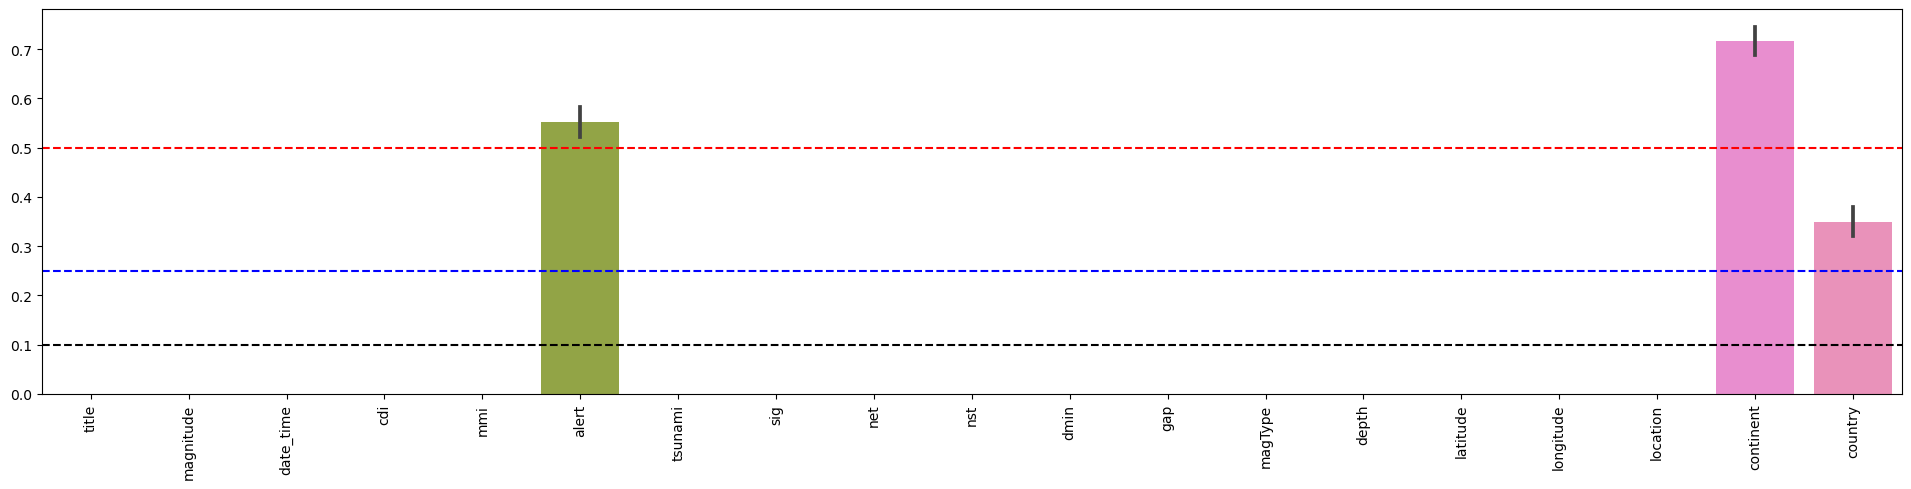

In [10]:
missing, ax = plt.subplots(figsize=(24, 5))
sns.barplot(data=df.isna(), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.axhline(0.5, ls='--', c='r')
ax.axhline(0.25, ls='--', c='b')
ax.axhline(0.1, ls='--', c='k')

<br>

1. Missing values for the 'alert' column will all be replaced with "no alert" since not every earthquake has an alert

2. The 'continent' column will be dropped as there are more than 70% missing values in this column, and we can also get the earthquake location information from the 'location', 'country', 'latitude' and 'longnitude' columns

3. Missing values for the "country" column will all be replaced with "Other" because we found that the location of the missing country is in the ocean or a very small island country and it cannot be found using its latitude and longitude

In [11]:
df['alert'] = df['alert'].fillna('no alert')
df = df.drop(columns=['continent'])
df['country'] = df['country'].fillna('Other')

In [12]:
pd.options.display.float_format = "{:,.2f}%".format
missing_percent = df.isnull().sum() * 100 / len(df)
df_missing_percent = pd.DataFrame(missing_percent, columns = ['Missing Value'])

print(df_missing_percent)
pd.reset_option('^display.', silent=True)

           Missing Value
title              0.00%
magnitude          0.00%
date_time          0.00%
cdi                0.00%
mmi                0.00%
alert              0.00%
tsunami            0.00%
sig                0.00%
net                0.00%
nst                0.00%
dmin               0.00%
gap                0.00%
magType            0.00%
depth              0.00%
latitude           0.00%
longitude          0.00%
location           0.00%
country            0.00%


<br>

## b. Outliers

Dataframe copied into two for further analysis and modeling
1. First dataframe remains outliers
2. Second dataframe will be removed outliers

In [13]:
df_outliers = df.copy()
df_no_outliers = df.copy()

Select numeric variables to visualize outlier

In [14]:
numeric_vars = ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth']

### Z-Score Method

Number of outliers for each column: 

magnitude : 10
cdi : 0
mmi : 1
sig : 23
nst : 3
dmin : 25
gap : 16
depth : 48


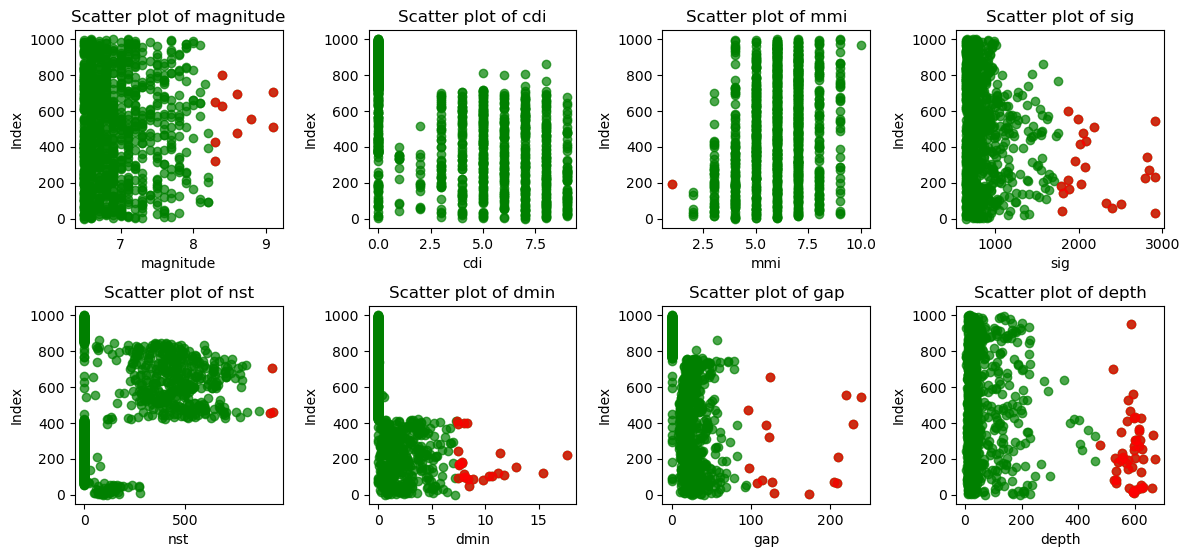

In [15]:
print("Number of outliers for each column: \n")
plt.figure(figsize=(12, 8))
for i, var in enumerate(numeric_vars):
    plt.subplot(3, 4, i + 1)
    plt.scatter(df[var], df.index, color='green', alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Index')
    plt.title(f'Scatter plot of {var}')

    # Calculate Z-scores for each data point in the variable using zscore function
    # np.abs((df[var] - df[var].mean()) / df[var].std())
    z_scores = stats.zscore(df[var])

    # Define a threshold for outliers (z-score > 3)
    threshold = 3

    # Detect and count the number of outliers
    outliers = df[np.abs(z_scores) > threshold]
    print(var, ":", outliers[var].count())

    # Plot and mark outliers using red color
    plt.scatter(outliers[var], outliers.index, color='red', alpha=0.7)

plt.tight_layout()
plt.show()

### IQR Method

Number for the outlier for each column: 

magnitude : 47
cdi : 0
mmi : 1
sig : 97
nst : 0
dmin : 96
gap : 29
depth : 165


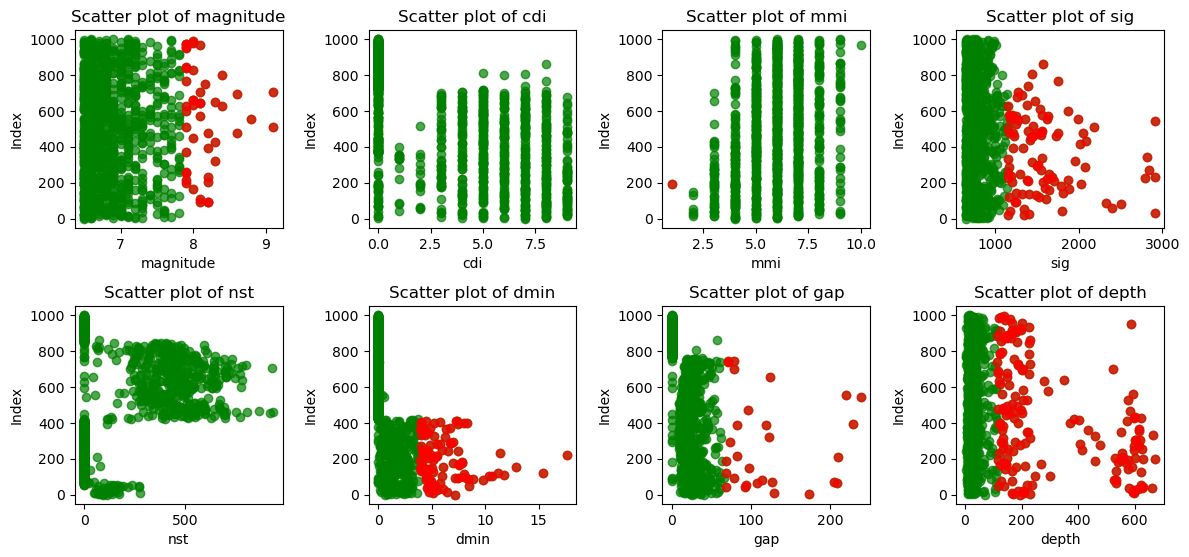

In [16]:
print("Number for the outlier for each column: \n")
plt.figure(figsize=(12, 8))
for i, var in enumerate(numeric_vars):
    plt.subplot(3, 4, i + 1)
    plt.scatter(df[var], df.index, color='green', alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Index')
    plt.title(f'Scatter plot of {var}')

    # Calculate IQR
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1

    # Define a threshold for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Detect and count the number of outliers
    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    print(var, ":", outliers[var].count())
    # Plot outliers
    plt.scatter(outliers[var], outliers.index, color='red', alpha=0.7)

plt.tight_layout()
plt.show()

<br>

In order to determine whether to use the Z-Score method or the IQR method to remove outliers, we will use the KDE plot to view the distribution of the data, because the Z-Score method only applies to normal distribution datasets, left-skewed or right-skewed data distributions will result in poorer performance

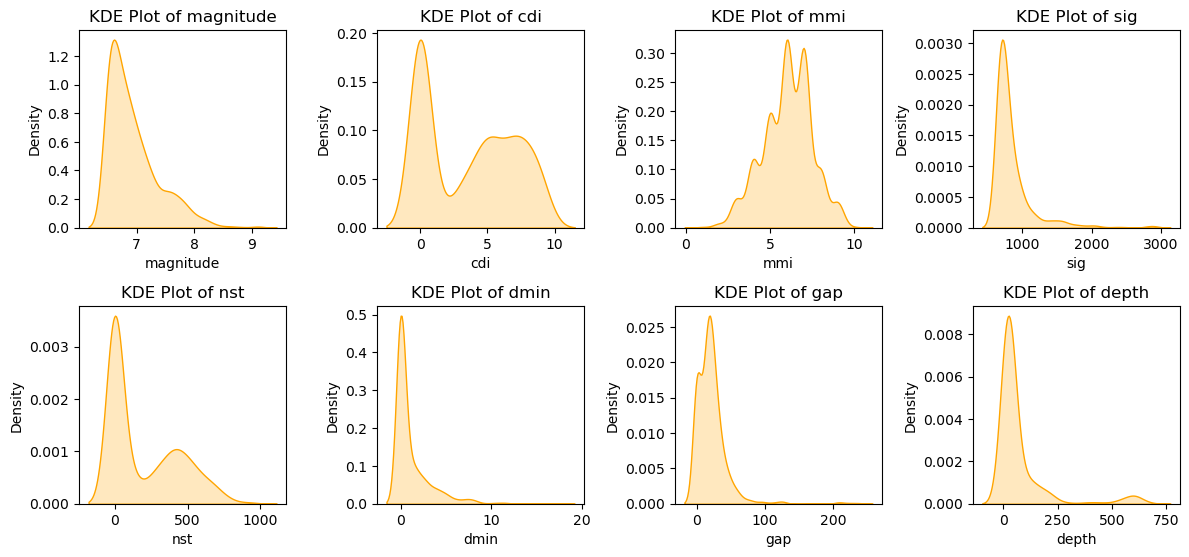

In [17]:
# Plotting KDE plots for each numeric variable
plt.figure(figsize=(12, 8))
for i, var in enumerate(numeric_vars):
    plt.subplot(3, 4, i + 1)
    sns.kdeplot(df[var], color='orange', fill=True)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.title(f'KDE Plot of {var}')

plt.tight_layout()
plt.show()

<br>

Since there is only one variable is having normal distribution, we consider to use IQR method to remove the outliers

In [18]:
# Using IQR to select outliers
def find_outlier_indexes_iqr(df, vars_to_remove_outliers):
    outlier_indexes = set()

    for var in vars_to_remove_outliers:

        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
        outlier_indexes.update(outliers.index)
    return outlier_indexes

# Find indexes of outliers for the specified variables
outlier_indexes = find_outlier_indexes_iqr(df_no_outliers, numeric_vars)

print(outlier_indexes, "\n")
print("Number of rows to be dropped:", len(outlier_indexes))

{0, 2, 4, 6, 7, 8, 11, 12, 15, 16, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30, 33, 37, 39, 40, 41, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 60, 63, 67, 68, 70, 71, 75, 77, 80, 81, 82, 83, 84, 85, 87, 88, 91, 92, 94, 95, 96, 98, 99, 100, 102, 104, 105, 108, 109, 112, 113, 118, 119, 120, 122, 123, 124, 127, 130, 131, 132, 133, 135, 139, 140, 141, 142, 143, 146, 147, 150, 151, 152, 153, 156, 160, 161, 164, 166, 168, 169, 170, 172, 173, 174, 176, 178, 179, 182, 183, 184, 186, 190, 191, 193, 194, 195, 196, 198, 201, 202, 203, 204, 205, 206, 208, 209, 210, 214, 215, 216, 217, 218, 219, 221, 224, 225, 226, 227, 230, 231, 232, 233, 234, 238, 240, 243, 244, 246, 247, 248, 249, 250, 252, 254, 256, 257, 258, 269, 270, 271, 273, 275, 277, 278, 280, 281, 285, 286, 287, 288, 289, 290, 292, 293, 294, 295, 298, 302, 303, 304, 313, 314, 320, 321, 324, 326, 329, 330, 333, 334, 336, 343, 345, 347, 349, 350, 351, 354, 360, 362, 363, 364, 365, 369, 370, 371, 385, 389, 390, 391, 393, 394, 396, 397, 399, 400,

- We can see that 363 rows will be removed from the dataset. It is about a third of the dataset, which means it will remove many rows and may affect the accuracy of our trained model
- So, we will try another mindset to remove the outliers
- We search the normal range for each variable and find the top 5 rows with the highest and lowest value for each variable in the dataframe to see whether the data falls outside the range or not.
- When the data falls outside the range, known as abnormal data point, we will treat it as an outlier and remove it

<br>

The magnitude range is between 1 to 10

In [19]:
top_5_highest_magnitude = df_no_outliers.sort_values(by='magnitude', ascending=False).head(5)
top_5_lowest_magnitude = df_no_outliers.sort_values(by='magnitude', ascending=False).tail(5)

frames = [top_5_highest_magnitude, top_5_lowest_magnitude]

result = pd.concat(frames)

result[['title', 'date_time', 'magnitude']]

title         date_time  \
703  M 9.1 - 2004 Sumatra - Andaman Islands Earthquake   26/12/2004 0:58   
511        M 9.1 - 2011 Great Tohoku Earthquake, Japan    11/3/2011 5:46   
552               M 8.8 - 36 km WNW of Quirihue, Chile    27/2/2010 6:34   
476     M 8.6 - off the west coast of northern Sumatra    11/4/2012 8:38   
692            M 8.6 - 78 km WSW of Singkil, Indonesia   28/3/2005 16:09   
805              M 6.5 - 41 km SSW of Ambon, Indonesia    19/3/2001 5:52   
297        M 6.5 - 227 km SE of Sarangani, Philippines   11/1/2016 16:38   
817      M 6.5 - 52 km ENE of Kokopo, Papua New Guinea   6/12/2000 22:57   
819          M 6.5 - 23 km SSE of Badamdar, Azerbaijan  25/11/2000 18:10   
0                     M 6.5 - 42 km W of Sola, Vanuatu   16/8/2023 12:47   

     magnitude  
703        9.1  
511        9.1  
552        8.8  
476        8.6  
692        8.6  
805        6.5  
297        6.5  
817        6.5  
819        6.5  
0          6.5

<br>

The cdi range is between 0 to 10

In [20]:
top_5_highest_cdi = df_no_outliers.sort_values(by='cdi', ascending=False).head(5)
top_5_lowest_cdi = df_no_outliers.sort_values(by='cdi', ascending=False).tail(5)

frames = [top_5_highest_cdi, top_5_lowest_cdi]

result = pd.concat(frames)

result[['title', 'date_time', 'cdi']]

title         date_time  cdi
479  M 7.4 - 6 km E of Santiago Llano Grande, Mexico   20/3/2012 18:02    9
128          M 7.8 - 99 km SSE of Perryville, Alaska    22/7/2020 6:12    9
266                M 6.9 - 35 km ESE of Namie, Japan  21/11/2016 20:59    9
554               M 7.0 - 10 km SE of L?og?ne, Haiti   12/1/2010 21:53    9
76                                M 7.3 - Flores Sea   14/12/2021 3:20    9
727               M 6.5 - 86 km NNW of Sola, Vanuatu    9/4/2004 15:23    0
726     M 6.7 - 105 km WNW of Naisano Dua, Indonesia    23/4/2004 1:50    0
725                 M 6.6 - 11 km N of Ca?ete, Chile     3/5/2004 4:36    0
724            M 6.9 - 24 km ENE of Atlasovo, Russia   10/6/2004 15:19    0
999        M 7.1 - 14 km NE of Cabatuan, Philippines     5/5/1995 3:53    0

<br>

The mmi range is between 1 to 10

In [21]:
top_5_highest_mmi = df_no_outliers.sort_values(by='mmi', ascending=False).head(5)
top_5_lowest_mmi = df_no_outliers.sort_values(by='mmi', ascending=False).tail(5)

frames = [top_5_highest_mmi, top_5_lowest_mmi]

result = pd.concat(frames)

result[['title', 'date_time', 'mmi']]

title        date_time  mmi
968            M 6.6 - 47 km N of Lijiang, China   3/2/1996 11:14   10
927               M 7.3 - 58 km E of Q???n, Iran   10/5/1997 7:57    9
974        M 7.2 - 27 km SSE of Nuwaybi??, Egypt  22/11/1995 4:15    9
678  M 7.6 - 21 km NNE of Muzaffar?b?d, Pakistan   8/10/2005 3:50    9
29                        M 7.8 - Central Turkey    6/2/2023 1:17    9
146       M 6.5 - 166km SSW of Ndoi Island, Fiji  8/11/2019 10:44    2
130         M 6.6 - 97 km N of Batang, Indonesia   6/7/2020 22:54    2
39                                      M 6.6 -   9/11/2022 10:14    2
52        M 6.5 - 107 km SSW of Tarauac?, Brazil    8/6/2022 0:55    2
195            M 6.5 - south of the Fiji Islands  16/9/2018 21:11    1

<br>

The sig range is between 0 to 1000

In [22]:
top_5_highest_sig = df_no_outliers.sort_values(by='sig', ascending=False).head(5)
top_5_lowest_sig = df_no_outliers.sort_values(by='sig', ascending=False).tail(5)

frames = [top_5_highest_sig, top_5_lowest_sig]

result = pd.concat(frames)

result[['title', 'date_time', 'sig']]

title        date_time   sig
542                M 7.2 - 12km SW of Delta, B.C., MX   4/4/2010 22:40  2910
233         M 8.2 - near the coast of Chiapas, Mexico    8/9/2017 4:49  2910
29                             M 7.8 - Central Turkey    6/2/2023 1:17  2910
270                  M 6.6 - 5 km ESE of Preci, Italy  30/10/2016 6:40  2840
343             M 7.8 - 67 km NNE of Bharatpur, Nepal   25/4/2015 6:11  2820
791                M 6.5 - 3 km NW of Hanamaki, Japan  2/12/2001 13:01   650
926              M 6.5 - 51 km S of Jurm, Afghanistan  13/5/1997 14:13   650
924  M 6.5 - 5 km ENE of Churumuco de Morelos, Mexico   22/5/1997 7:50   650
796        M 6.5 - 108 km WNW of Manokwari, Indonesia  11/9/2001 14:56   650
761     M 6.5 - 33 km S of Puerto San Jos?, Guatemala   21/1/2003 2:46   650

Since there are some rows exceed the 1000, we will remove it

In [23]:
rows_to_delete = df_no_outliers[df_no_outliers['sig'] > 1000]
print("Number of rows to be removed:", len(rows_to_delete.index))

df_no_outliers = df_no_outliers.drop(index=rows_to_delete.index)
df_no_outliers.reset_index(drop=True, inplace=True)

print("Remaining rows:", len(df_no_outliers))

Number of rows to be removed: 147
Remaining rows: 853


<br>

The nst range is uncertainly because it is the total number of seismic stations used to determine earthquake location, and it can be more or less, so we will not try to remove any rows from this variable

In [24]:
top_5_highest_nst = df_no_outliers.sort_values(by='nst', ascending=False).head(5)
top_5_lowest_nst = df_no_outliers.sort_values(by='nst', ascending=False).tail(5)

frames = [top_5_highest_nst, top_5_lowest_nst]

result = pd.concat(frames)

result[['title', 'date_time', 'nst']]

title         date_time  nst
567          M 7.0 - 51 km SW of Nemuro, Japan  28/11/2004 18:32  929
380    M 7.7 - 156 km ENE of Poronaysk, Russia    14/8/2012 2:59  862
584      M 6.9 - 24 km ENE of Atlasovo, Russia   10/6/2004 15:19  798
574           M 6.6 - 8 km SSW of Ojiya, Japan   23/10/2004 8:56  782
512    M 6.6 - 20 km NNW of Kashiwazaki, Japan    16/7/2007 1:13  782
190  M 6.8 - 200 km NW of Attu Station, Alaska    2/6/2017 22:24    0
191       M 6.6 - 37 km WNW of Poso, Indonesia   29/5/2017 14:35    0
192      M 6.5 - South Sandwich Islands region   10/5/2017 23:23    0
193    M 6.8 - 59 km NNE of Port-Olry, Vanuatu    9/5/2017 13:52    0
852  M 7.1 - 14 km NE of Cabatuan, Philippines     5/5/1995 3:53    0

<br>

The dmin range is between 0 to 7.1

In [25]:
top_5_highest_dmin = df_no_outliers.sort_values(by='dmin', ascending=False).head(5)
top_5_lowest_dmin = df_no_outliers.sort_values(by='dmin', ascending=False).tail(5)

frames = [top_5_highest_dmin, top_5_lowest_dmin]

result = pd.concat(frames)

result[['title', 'date_time', 'dmin']]

title         date_time  \
177                       M 6.5 - Bouvet Island region  13/12/2017 18:03   
101                 M 6.5 - central Mid-Atlantic Ridge   30/8/2020 21:20   
125  M 6.6 - 131km S of Bristol Island, South Sandw...   27/8/2019 23:55   
90                     M 6.5 - Kermadec Islands region    4/3/2021 23:12   
186                   M 6.5 - 168 km SW of Mawu, China    8/8/2017 13:19   
502            M 6.7 - 118 km SSW of Padang, Indonesia    20/9/2007 8:31   
501     M 6.8 - 154 km ESE of Kokopo, Papua New Guinea   26/9/2007 12:36   
500            M 6.8 - 70 km N of Te Anau, New Zealand  15/10/2007 12:29   
499            M 6.8 - 138 km W of Bengkulu, Indonesia  24/10/2007 21:02   
852          M 7.1 - 14 km NE of Cabatuan, Philippines     5/5/1995 3:53   

       dmin  
177  17.654  
101  15.394  
125  12.896  
90   11.764  
186  11.411  
502   0.000  
501   0.000  
500   0.000  
499   0.000  
852   0.000

Since there are some rows exceed the 7.1, we will remove it

In [26]:
rows_to_delete = df_no_outliers[df_no_outliers['dmin'] > 7.1]
print("Number of rows to be removed:", len(rows_to_delete.index))

df_no_outliers = df_no_outliers.drop(index=rows_to_delete.index)
df_no_outliers.reset_index(drop=True, inplace=True)

print("Remaining rows:", len(df_no_outliers))

Number of rows to be removed: 24
Remaining rows: 829


<br>

The gap range is between 0 to 180

In [27]:
top_5_highest_gap = df_no_outliers.sort_values(by='gap', ascending=False).head(5)
top_5_lowest_gap = df_no_outliers.sort_values(by='gap', ascending=False).tail(5)

frames = [top_5_highest_gap, top_5_lowest_gap]

result = pd.concat(frames)

result[['title', 'date_time', 'gap']]

title        date_time    gap
58        M 6.5 - 71 km SE of Nikolski, Alaska  11/1/2022 12:39  208.8
61        M 6.7 - 91 km SE of Nikolski, Alaska  11/1/2022 11:35  205.2
3                     M 7.3 - Alaska Peninsula   16/7/2023 6:48  172.8
7        M 6.6 - Panama-Colombia border region   25/5/2023 3:05  129.0
60        M 6.7 - 91 km SE of Nikolski, Alaska  11/1/2022 11:35  126.0
672                 M 7.9 - South Indian Ocean  18/6/2000 14:44    0.0
673        M 6.5 - 25 km E of Selfoss, Iceland  17/6/2000 15:40    0.0
674   M 6.7 - 98 km SSW of Bengkulu, Indonesia   7/6/2000 23:45    0.0
675     M 6.7 - 95 km S of Bengkulu, Indonesia   4/6/2000 16:39    0.0
828  M 7.1 - 14 km NE of Cabatuan, Philippines    5/5/1995 3:53    0.0

Since there are some rows exceed the 180, we will remove it

In [28]:
rows_to_delete = df_no_outliers[df_no_outliers['gap'] > 180]
print("Number of rows to be removed:", len(rows_to_delete.index))

df_no_outliers = df_no_outliers.drop(index=rows_to_delete.index)
df_no_outliers.reset_index(drop=True, inplace=True)

print("Remaining rows:", len(df_no_outliers))

Number of rows to be removed: 2
Remaining rows: 827


<br>

The depth range is between 0 to 1000

In [29]:
top_5_highest_depth = df_no_outliers.sort_values(by='depth', ascending=False).head(5)
top_5_lowest_depth = df_no_outliers.sort_values(by='depth', ascending=False).tail(5)

frames = [top_5_highest_depth, top_5_lowest_depth]

result = pd.concat(frames)

result[['title', 'date_time', 'depth']]

title         date_time  \
144                    M 7.9 - 45 km S of Levuka, Fiji    6/9/2018 15:49   
35                   M 7.0 - south of the Fiji Islands    9/11/2022 9:51   
36                   M 6.8 - south of the Fiji Islands    9/11/2022 9:38   
146                  M 7.1 - 136 km W of I?apari, Peru    24/8/2018 9:04   
178        M 7.3 - 189 km SSE of Tabiauan, Philippines    10/1/2017 6:13   
616              M 6.5 - 5 km NE of Sultanda??, Turkey     3/2/2002 7:11   
757  M 6.7 - 18 km WSW of Scarborough, Trinidad and...    22/4/1997 9:31   
168          M 6.8 - 200 km NW of Attu Station, Alaska    2/6/2017 22:24   
556                   M 6.5 - 67 km ESE of Teno, Chile   28/8/2004 13:41   
598              M 6.6 - 53 km ENE of Cantwell, Alaska  23/10/2002 11:27   

       depth  
144  670.810  
35   660.000  
36   630.379  
146  630.000  
178  627.170  
616    5.000  
757    5.000  
168    5.000  
556    5.000  
598    4.200

<br>

The latitude range is between -90 to 90 (90° South ~ 90° North)

In [30]:
top_5_highest_latitude = df_no_outliers.sort_values(by='latitude', ascending=False).head(5)
top_5_lowest_latitude = df_no_outliers.sort_values(by='latitude', ascending=False).tail(5)

frames = [top_5_highest_latitude, top_5_lowest_latitude]

result = pd.concat(frames)

result[['title', 'date_time', 'latitude']]

title         date_time  latitude
335  M 6.6 - 183 km SW of Belaya Gora, Russia   14/2/2013 13:13   67.6310
669     M 6.5 - 12 km ENE of Selfoss, Iceland    21/6/2000 0:51   63.9800
671       M 6.5 - 25 km E of Selfoss, Iceland   17/6/2000 15:40   63.9660
598     M 6.6 - 53 km ENE of Cantwell, Alaska  23/10/2002 11:27   63.5144
509     M 7.6 - 80 km NE of Tilichiki, Russia   20/4/2006 23:25   60.9490
170     M 6.5 - South Sandwich Islands region   10/5/2017 23:23  -56.4140
128     M 7.1 - South Sandwich Islands region   11/12/2018 2:26  -58.5446
582                        M 7.6 - Scotia Sea     4/8/2003 4:37  -60.5320
318     M 7.3 - South Sandwich Islands region   15/7/2013 14:03  -60.8570
81             M 6.9 - South Shetland Islands   23/1/2021 23:36  -61.8484

<br>

The longitude range is between -180 to 180 (180° West ~ 180° East)

In [31]:
top_5_highest_longitude = df_no_outliers.sort_values(by='longitude', ascending=False).head(5)
top_5_lowest_longitude = df_no_outliers.sort_values(by='longitude', ascending=False).tail(5)

frames = [top_5_highest_longitude, top_5_lowest_longitude]

result = pd.concat(frames)

result[['title', 'date_time', 'longitude']]

title         date_time  longitude
265  M 6.7 - 183 km NE of Gisborne, New Zealand  16/11/2014 22:33    179.662
80   M 7.3 - 182 km NE of Gisborne, New Zealand    4/3/2021 13:27    179.544
14            M 6.7 - south of the Fiji Islands    18/4/2023 4:31    179.391
144             M 7.9 - 45 km S of Levuka, Fiji    6/9/2018 15:49    179.350
193  M 7.0 - 175 km NE of Gisborne, New Zealand    1/9/2016 16:37    179.146
42        M 6.6 - south of the Kermadec Islands   14/8/2022 13:44   -178.959
142             M 6.9 - Kermadec Islands region    10/9/2018 4:19   -179.373
733          M 6.7 - 149 km ENE of Labasa, Fiji   12/1/1998 16:36   -179.376
103      M 6.5 - 166km SSW of Ndoi Island, Fiji   8/11/2019 10:44   -179.511
53            M 6.8 - south of the Fiji Islands   16/2/2022 20:21   -179.968

After removing the outliers (173 rows), that is left 827 rows in the dataframe

<br>

## c. Data Type Issues

Definition of Data Type Issues:
- Data type of the variables is incorrect
- Especially for the data and time variable

In [32]:
df.dtypes

title         object
magnitude    float64
date_time     object
cdi            int64
mmi            int64
alert         object
tsunami        int64
sig            int64
net           object
nst            int64
dmin         float64
gap          float64
magType       object
depth        float64
latitude     float64
longitude    float64
location      object
country       object
dtype: object

<br>
We can see the date_time column in the dataframe is a string object, so we need to convert it into the correct date format

In [33]:
df_outliers['date_time'] = pd.to_datetime(df_outliers['date_time'])
df_no_outliers['date_time'] = pd.to_datetime(df_no_outliers['date_time'])
print(df_no_outliers.dtypes)
df_no_outliers.head(5)

title                object
magnitude           float64
date_time    datetime64[ns]
cdi                   int64
mmi                   int64
alert                object
tsunami               int64
sig                   int64
net                  object
nst                   int64
dmin                float64
gap                 float64
magType              object
depth               float64
latitude            float64
longitude           float64
location             object
country              object
dtype: object


title  magnitude  \
0           M 6.5 - 43 km S of Intipuc?, El Salvador        6.5   
1           M 6.6 - 25 km ESE of Loncopu?, Argentina        6.6   
2              M 7.2 - 98 km S of Sand Point, Alaska        7.2   
3                           M 7.3 - Alaska Peninsula        7.3   
4  M 6.6 - 277 km NNE of Codrington, Antigua and ...        6.6   

            date_time  cdi  mmi     alert  tsunami  sig net  nst      dmin  \
0 2023-07-19 00:22:00    8    6    yellow        0  775  us   92  0.679000   
1 2023-07-17 03:05:00    7    5     green        0  899  us   70  1.634000   
2 2023-07-16 06:48:00    6    6     green        1  860  us  173  0.907000   
3 2023-07-16 06:48:00    0    5  no alert        1  820  at   79  0.879451   
4 2023-10-07 20:28:00    5    4     green        1  802  us   95  2.454000   

     gap magType    depth  latitude  longitude  \
0   40.0     mww   69.727   12.8140   -88.1265   
1   28.0     mww  171.371  -38.1911   -70.3731   
2   36.0     mww   32.571   54.3844  -160.6990   
3  172.8      Mi   21.000   54.4900  -160.7960   
4   37.0     mww   10.000   20.0196   -61.0955   

                          location    country  
0            Intipuc?, El Salvador      Other  
1              Loncopu?, Argentina  Argentina  
2               Sand Point, Alaska      Other  
3                 Alaska Peninsula      Other  
4  Codrington, Antigua and Barbuda      Other

<br>

## d. Contaminated Data

Definition of Contaminated Data:
- Data that is irrelevant to the dataset(topic)
- Data that is in the wrong column
- Data that is having errors while input or transmit
- Future data exist in current data
- Training data contains test data


1. Since we are not the expert in the earthquake field, we cannot justify which variable is having wrong or correct value
2. However, we can check whether the dates in the dataframe have any future data or not, since it is earthquake data collected from 1995 to 2023

In [34]:
exceeds_2024 = (df_outliers['date_time'].dt.year > 2024).any()

if exceeds_2024:
    print("There are rows exceed 2024")
else:
    print("No row is exceed 2024 in outliers dataframe")

No row is exceed 2024 in outliers dataframe


In [35]:
exceeds_2024 = (df_no_outliers['date_time'].dt.year > 2024).any()

if exceeds_2024:
    print("There are rows exceed 2024")
else:
    print("No row is exceed 2024 in no outliers dataframe")

No row is exceed 2024 in no outliers dataframe


<br>

## e. Inconsistent Data

Definition of Inconsistent Data:
- Data are same, but express in different ways
- Due to strange naming conventions, typos, or incorrect capitalization
- Need to make it all in same word or expression, so that computer think that they are all same thing

1. Change the title to lowercase
2. Check for the name of the country is correct or not using pycountry library

In [36]:
df_outliers['title'] = df_outliers['title'].str.lower()
df_no_outliers['title'] = df_no_outliers['title'].str.lower()

In [37]:
# pycountry is case-sensitive

pycountry_names = [country.name for country in pycountry.countries]
pycountry_names.append("Other")

def check_country_name(country_name):
    return country_name in pycountry_names


In [38]:
df_outliers['is_valid_country'] = df_outliers['country'].apply(check_country_name)

df_outliers

title  magnitude           date_time  \
0             m 6.5 - 42 km w of sola, vanuatu        6.5 2023-08-16 12:47:00   
1     m 6.5 - 43 km s of intipuc?, el salvador        6.5 2023-07-19 00:22:00   
2     m 6.6 - 25 km ese of loncopu?, argentina        6.6 2023-07-17 03:05:00   
3        m 7.2 - 98 km s of sand point, alaska        7.2 2023-07-16 06:48:00   
4                     m 7.3 - alaska peninsula        7.3 2023-07-16 06:48:00   
..                                         ...        ...                 ...   
995          m 7.1 - 85 km s of tungor, russia        7.1 1995-05-27 13:03:00   
996     m 7.7 - 249 km e of vao, new caledonia        7.7 1995-05-16 20:12:00   
997  m 6.9 - 27 km nnw of maubara, timor leste        6.9 1995-05-14 11:33:00   
998           m 6.6 - 10 km w of aian?, greece        6.6 1995-05-13 08:47:00   
999  m 7.1 - 14 km ne of cabatuan, philippines        7.1 1995-05-05 03:53:00   

     cdi  mmi     alert  tsunami  sig net  nst      dmin    gap magType  \
0      7    4     green        0  657  us  114  7.177000   25.0     mww   
1      8    6    yellow        0  775  us   92  0.679000   40.0     mww   
2      7    5     green        0  899  us   70  1.634000   28.0     mww   
3      6    6     green        1  860  us  173  0.907000   36.0     mww   
4      0    5  no alert        1  820  at   79  0.879451  172.8      Mi   
..   ...  ...       ...      ...  ...  ..  ...       ...    ...     ...   
995    0    9  no alert        0  776  us    0  0.000000    0.0     mwb   
996    0    4  no alert        0  912  us    0  0.000000    0.0      mw   
997    0    6  no alert        0  732  us    0  0.000000    0.0      mw   
998    0    9  no alert        0  670  us    0  0.000000    0.0      mw   
999    0    7  no alert        0  776  us    0  0.000000    0.0      mw   

       depth  latitude  longitude               location      country  \
0    192.955  -13.8814   167.1580          Sola, Vanuatu      Vanuatu   
1     69.727   12.8140   -88.1265  Intipuc?, El Salvador        Other   
2    171.371  -38.1911   -70.3731    Loncopu?, Argentina    Argentina   
3     32.571   54.3844  -160.6990     Sand Point, Alaska        Other   
4     21.000   54.4900  -160.7960       Alaska Peninsula        Other   
..       ...       ...        ...                    ...          ...   
995   11.000   52.6290   142.8270         Tungor, Russia       Russia   
996   20.200  -23.0080   169.9000     Vao, New Caledonia        Other   
997   11.200   -8.3780   125.1270   Maubara, Timor Leste    Indonesia   
998   14.000   40.1490    21.6950          Aian?, Greece       Greece   
999   16.000   12.6260   125.2970  Cabatuan, Philippines  Philippines   

     is_valid_country  
0                True  
1                True  
2                True  
3                True  
4                True  
..                ...  
995             False  
996              True  
997              True  
998              True  
999              True  

[1000 rows x 19 columns]

In [39]:
df_no_outliers['is_valid_country'] = df_no_outliers['country'].apply(check_country_name)

df_no_outliers

title  magnitude  \
0             m 6.5 - 43 km s of intipuc?, el salvador        6.5   
1             m 6.6 - 25 km ese of loncopu?, argentina        6.6   
2                m 7.2 - 98 km s of sand point, alaska        7.2   
3                             m 7.3 - alaska peninsula        7.3   
4    m 6.6 - 277 km nne of codrington, antigua and ...        6.6   
..                                                 ...        ...   
822                  m 7.1 - 85 km s of tungor, russia        7.1   
823             m 7.7 - 249 km e of vao, new caledonia        7.7   
824          m 6.9 - 27 km nnw of maubara, timor leste        6.9   
825                   m 6.6 - 10 km w of aian?, greece        6.6   
826          m 7.1 - 14 km ne of cabatuan, philippines        7.1   

              date_time  cdi  mmi     alert  tsunami  sig net  nst      dmin  \
0   2023-07-19 00:22:00    8    6    yellow        0  775  us   92  0.679000   
1   2023-07-17 03:05:00    7    5     green        0  899  us   70  1.634000   
2   2023-07-16 06:48:00    6    6     green        1  860  us  173  0.907000   
3   2023-07-16 06:48:00    0    5  no alert        1  820  at   79  0.879451   
4   2023-10-07 20:28:00    5    4     green        1  802  us   95  2.454000   
..                  ...  ...  ...       ...      ...  ...  ..  ...       ...   
822 1995-05-27 13:03:00    0    9  no alert        0  776  us    0  0.000000   
823 1995-05-16 20:12:00    0    4  no alert        0  912  us    0  0.000000   
824 1995-05-14 11:33:00    0    6  no alert        0  732  us    0  0.000000   
825 1995-05-13 08:47:00    0    9  no alert        0  670  us    0  0.000000   
826 1995-05-05 03:53:00    0    7  no alert        0  776  us    0  0.000000   

       gap magType    depth  latitude  longitude  \
0     40.0     mww   69.727   12.8140   -88.1265   
1     28.0     mww  171.371  -38.1911   -70.3731   
2     36.0     mww   32.571   54.3844  -160.6990   
3    172.8      Mi   21.000   54.4900  -160.7960   
4     37.0     mww   10.000   20.0196   -61.0955   
..     ...     ...      ...       ...        ...   
822    0.0     mwb   11.000   52.6290   142.8270   
823    0.0      mw   20.200  -23.0080   169.9000   
824    0.0      mw   11.200   -8.3780   125.1270   
825    0.0      mw   14.000   40.1490    21.6950   
826    0.0      mw   16.000   12.6260   125.2970   

                            location      country  is_valid_country  
0              Intipuc?, El Salvador        Other              True  
1                Loncopu?, Argentina    Argentina              True  
2                 Sand Point, Alaska        Other              True  
3                   Alaska Peninsula        Other              True  
4    Codrington, Antigua and Barbuda        Other              True  
..                               ...          ...               ...  
822                   Tungor, Russia       Russia             False  
823               Vao, New Caledonia        Other              True  
824             Maubara, Timor Leste    Indonesia              True  
825                    Aian?, Greece       Greece              True  
826            Cabatuan, Philippines  Philippines              True  

[827 rows x 19 columns]

<br>

There are some invalid or inconsistency country name, we will find out the their invalid name using unique() function

In [40]:
invalid_countries = df_outliers.loc[~df_outliers['is_valid_country'], 'country']

# Get unique invalid country names
unique_invalid_countries = invalid_countries.unique()

# Print the distinct invalid country names
print("Distinct invalid country names (outliers):")
print(unique_invalid_countries)

Distinct invalid country names (outliers):
['Russian Federation (the)' 'Turkiye' 'Taiwan'
 "People's Republic of China" 'United States of America' 'Russia' 'Turkey'
 'United Kingdom of Great Britain and Northern Ireland (the)' 'Venezuela'
 'Bolivia' 'Iran' 'Tanzania']


In [41]:
invalid_countries = df_no_outliers.loc[~df_no_outliers['is_valid_country'], 'country']

# Get unique invalid country names
unique_invalid_countries = invalid_countries.unique()

# Print the distinct invalid country names
print("Distinct invalid country names (no outliers):")
print(unique_invalid_countries)

Distinct invalid country names (no outliers):
['Russian Federation (the)' 'Turkiye' 'Taiwan' 'United States of America'
 'Russia' 'Bolivia' "People's Republic of China"
 'United Kingdom of Great Britain and Northern Ireland (the)' 'Iran'
 'Tanzania' 'Turkey' 'Venezuela']


<br>

- After checking for the distinct invalid country names, we find their real country code to get the country name record in the pycountry
- Then we will manually change it to the correct form.

In [42]:
country_codes_alpha_3 = ['RUS', 'TUR', 'TWN', 'USA', 'BOL', 'CHN', 'GBR', 'IRN', 'TZA', 'VEN']

# Iterate over each country code and retrieve country information
for alpha_3_code in country_codes_alpha_3:
    # Get country information for the current code
    country = pycountry.countries.get(alpha_3=alpha_3_code)

    # Print country information if found
    if country:
        print("ISO 3166 country code (alpha-3):", alpha_3_code)
        print("Country name:", country.name, "\n")
    else:
        print("Country not found for code:", code, "\n")

ISO 3166 country code (alpha-3): RUS
Country name: Russian Federation 

ISO 3166 country code (alpha-3): TUR
Country name: Türkiye 

ISO 3166 country code (alpha-3): TWN
Country name: Taiwan, Province of China 

ISO 3166 country code (alpha-3): USA
Country name: United States 

ISO 3166 country code (alpha-3): BOL
Country name: Bolivia, Plurinational State of 

ISO 3166 country code (alpha-3): CHN
Country name: China 

ISO 3166 country code (alpha-3): GBR
Country name: United Kingdom 

ISO 3166 country code (alpha-3): IRN
Country name: Iran, Islamic Republic of 

ISO 3166 country code (alpha-3): TZA
Country name: Tanzania, United Republic of 

ISO 3166 country code (alpha-3): VEN
Country name: Venezuela, Bolivarian Republic of 



In [43]:
invalid_country = ["Russian Federation (the)", "Turkiye", "Taiwan", "United States of America", "Russia", 
                   "Bolivia", "People's Republic of China", "United Kingdom of Great Britain and Northern Ireland (the)", "Iran", 
                   "Tanzania", "Turkey", "Venezuela"]

valid_country = ["Russian Federation", "Türkiye", "Taiwan, Province of China", "United States", "Russian Federation", 
                 "Bolivia, Plurinational State of", "China", "United Kingdom", "Iran, Islamic Republic of", 
                   "Tanzania, United Republic of", "Türkiye", "Venezuela, Bolivarian Republic of"]

j = 0

for i in invalid_country: 
    df_outliers['country'] = df_outliers['country'].replace(i, valid_country[j])
    df_no_outliers['country'] = df_no_outliers['country'].replace(i, valid_country[j])

df_outliers = df_outliers.drop(columns=['is_valid_country'])
df_no_outliers = df_no_outliers.drop(columns=['is_valid_country'])

In [44]:
df_outliers['is_valid_country'] = df_outliers['country'].apply(check_country_name)

if False in df_outliers['is_valid_country'].values:
    print("Still have not valid country")
else:
    print("All country names in outliers dataframe are now correct and consistency")

All country names in outliers dataframe are now correct and consistency


In [45]:
df_no_outliers['is_valid_country'] = df_no_outliers['country'].apply(check_country_name)

if False in df_no_outliers['is_valid_country'].values:
    print("Still have not valid country")
else:
    print("All country names in no outliers dataframe are now correct and consistency")

All country names in no outliers dataframe are now correct and consistency


<br>

## f. Invalid Data

Definition of Invalid Data:
- Similar to the corrupted data(contaminated data), invalid data is illogical
- But it happens when the functions has the limitation
- Function computing with bug and give illogical result(data)

<br>

1. Since it has similarities with the contaminated data done above, and the results of each variable are from the official website according to the author of the dataset, so it will not occur function computational error
2. Hence we do nothing in this part

<br>
Official website: https://www.usgs.gov/ 
<br>
Source: https://www.kaggle.com/datasets/warcoder/earthquake-dataset/discussion/393389

<br>

## g. Duplicate Data

Definition of Duplicate Data:
- Duplicate observation happens in a dataframe

<br>

We will check whether any duplicates exist or not in the dataframe

In [46]:
has_duplicates = df_outliers.duplicated().any()

if has_duplicates:
    print("Duplicate occurs in outliers dataframe")
else:
    print("There are no duplicate rows in outliers dataframe")


There are no duplicate rows in outliers dataframe


In [47]:
has_duplicates = df_no_outliers.duplicated().any()

if has_duplicates:
    print("Duplicate occurs in no outliers dataframe")
else:
    print("There are no duplicate rows in no outliers dataframe")


There are no duplicate rows in no outliers dataframe


<br>

## h. Structural Errors

Definition of Structural Errors:
- Structural errors arise during measurement, data transfer, or other situations
- Structural errors can lead to inconsistent data, data duplication, or contamination
- Cannot be solved by applying cleaning techniques
- The ways to be solved are check ETL pipeline
- and how the collection and transformation of data from raw data source to identify structural error

<br>

1. Since this error cannot be solved by applying cleaning techniques
2. And the data from raw data source is come from official website according to the author of the dataset
3. Hence we do nothing in this part

<br>
Official website: https://www.usgs.gov/ 
<br>
Source: https://www.kaggle.com/datasets/warcoder/earthquake-dataset/discussion/393389

<br>

# Visualization & Exploratory Data Analysis insight & Descriptive Analysis

*   **title**: title name given to the earthquake
*   **magnitude**: The magnitude of the earthquake
*   **date_time**: date and time
*   **cdi**: The maximum reported intensity for the event range
*   **mmi**: The maximum estimated instrumental intensity for the event
*   **alert**: The alert level
*   **tsunami**: "1" for events in oceanic regions and "0" otherwise
*   **sig**: A number describing how significant the event is. Larger numbers indicate a more significant event.
*   **net**: The ID of a data contributor. Identifies the network considered to be the preferred source of information for this event.
*   **nst**: The total number of seismic stations used to determine earthquake location.
*   **dmin**: Horizontal distance from the epicenter to the nearest station
*   **gap**: The largest azimuthal gap between azimuthally adjacent stations (in degrees).
*   **magType**: The method or algorithm used to calculate the preferred magnitude for the event
*   **depth**: The depth where the earthquake begins to rupture
*   **latitude / longitude**: coordinate system by means of which the position or location of any place on Earth's surface can be determined and described
*   **location**: location within the country
*   **country**: affected country
























In [48]:
df = df_no_outliers.copy()

In [49]:
# Plot a figure to show the earthquakes across the world
print("Earthquakes Across the World  -  Heat Map")
world = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=1)
heat_map = df[["latitude", "longitude"]].values
world.add_child(plugins.HeatMap(heat_map, min_opacity=0.3, radius=13))
world

Earthquakes Across the World  -  Heat Map


In [50]:
# View the infomation about magnitude column
df['magnitude'].describe()

count    827.000000
mean       6.867836
std        0.354877
min        6.500000
25%        6.600000
50%        6.800000
75%        7.000000
max        8.000000
Name: magnitude, dtype: float64

In [51]:
# Plot a figure to show the location and impact of earthquakes
dff1= df.copy()
dff1.loc[:, 'magnitude_level']= pd.cut(dff1['magnitude'], bins=[6.5, 7, 7.5, 8], labels=['6.5-7', '7-7.5', '7.5-8'])

fig1 = px.scatter_geo(dff1, lat='latitude', lon='longitude',
                      hover_name='title', size='sig',
                      color='magnitude_level',
                      color_discrete_map={
                          '6.5-7': 'green',
                          '7-7.5': 'orange',
                          '7.5-8': 'red',
                      })


fig1.update_geos(projection_type="natural earth", showcountries=True, showcoastlines=True)
fig1.update_layout(title="Visualizing Earthquake Location and Impact")
fig1.show()


1.   It's possible to visualize the concentration of seismic activity circling the Pacific Ocean, bordering the far east countries by sea, and the west coast of the American continent. They are often observed close to tectonic plate borders where geological activity is more intense.

2.   A second, smaller, but relevant concentration can be observed crossing the Asian continent from Southeast Asia all the way through the mediterranean sea and into the European Continent. This geological path is the result of another active tectonic region, caused by the encounter of four different plates, them being the Eurasian Plate from one side, and the Australian, Indian, and Arabian Plates from the other.



Text(0.5, 0, 'Tsunami Occurence (0 = No, 1 = Yes)')

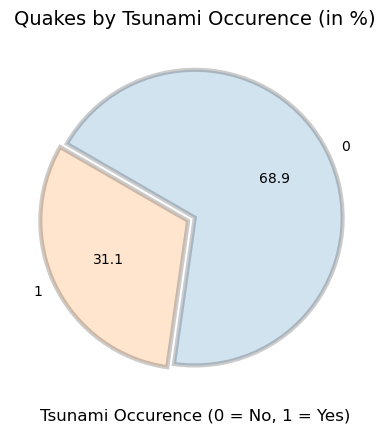

In [52]:
# Plot a figure to show the percentage of tsunami occure
plt.title('Quakes by Tsunami Occurence (in %)',fontsize=14)
my_xpl = [0.0, 0.05]
df['tsunami'].value_counts().plot(kind='pie', explode=my_xpl, legend=None, ylabel='', counterclock=False, startangle=150, wedgeprops={'alpha':0.2, 'edgecolor' : 'black','linewidth': 3, 'antialiased': True}, autopct='%1.1f')
plt.xlabel('Tsunami Occurence (0 = No, 1 = Yes)',fontsize=12)

**"1"** stands for earthquakes occured in oceanic regions causing tsunami and other oceanic events.


In [53]:
# Plot a figure to show the location and impact of tsunami
tsun = df[df['tsunami'] == 1].copy()
tsun.loc[:, 'magnitude_level'] = pd.cut(tsun['magnitude'], bins=[6.5, 7, 7.5, 8], labels=['6.5-7', '7-7.5', '7.5-8'])


fig2 = px.scatter_geo(tsun, lat='latitude', lon='longitude',
                      hover_name='title', size='sig',
                      color='magnitude_level',
                      color_discrete_map={
                          '6.5-7': 'green',
                          '7-7.5': 'orange',
                          '7.5-8': 'red',
                      })

fig2.update_geos(projection_type="natural earth", showcountries=True, showcoastlines=True)
fig2.update_layout(title="Visualizing Tsunami Location and Impact")
fig2.show()


*   It's possible to visualize the concentration of tsunami circling the **Pacific Ocean**




In [54]:
dfa = df.copy()

# Convert 'date_time' column to datetime format
dfa['date_time'] = pd.to_datetime(df['date_time'])

# Extract day of the month from 'date_time' column
dfa['day'] = dfa['date_time'].dt.day
dfa['month'] = dfa['date_time'].dt.month

# Group by month and day, then count occurrences
monthly_day_counts = dfa.groupby(['month', 'day']).size().reset_index(name='count')

# Define discrete color scale thresholds
color_discrete_map = {
    (1, 2): 'blue',
    (3, 4): 'yellow',
    (5, 6): 'orange',
    (7, float('inf')): 'red'
}

# Create plot that show when have the most earthquakes
fig = px.scatter(monthly_day_counts, x='day', y='month', size='count',
                 color='count',
                 color_discrete_map=color_discrete_map,
                 labels={'day': 'Day of Month', 'month': 'Month', 'count': 'Number of Earthquakes'},
                 title='Distribution of Earthquake Occurrences by Day in Each Month')
fig.update_layout(xaxis={'title': 'Day of Month'},
                  yaxis={'title': 'Month'},
                  plot_bgcolor='white',
                  paper_bgcolor='white')
fig.show()





*   From this chart, we can find that there is **no obvious pattern** in the occurrence of earthquakes.




In [55]:
dff = df.copy()
dff['Date'] = pd.to_datetime(dff['date_time']).dt.date
dff['Year'] = pd.to_datetime(dff['date_time']).dt.year
dff['Month'] = pd.to_datetime(dff['date_time']).dt.month
dff['Day'] = pd.to_datetime(dff['date_time']).dt.day
dff['Hour'] = pd.to_datetime(dff['date_time']).dt.hour

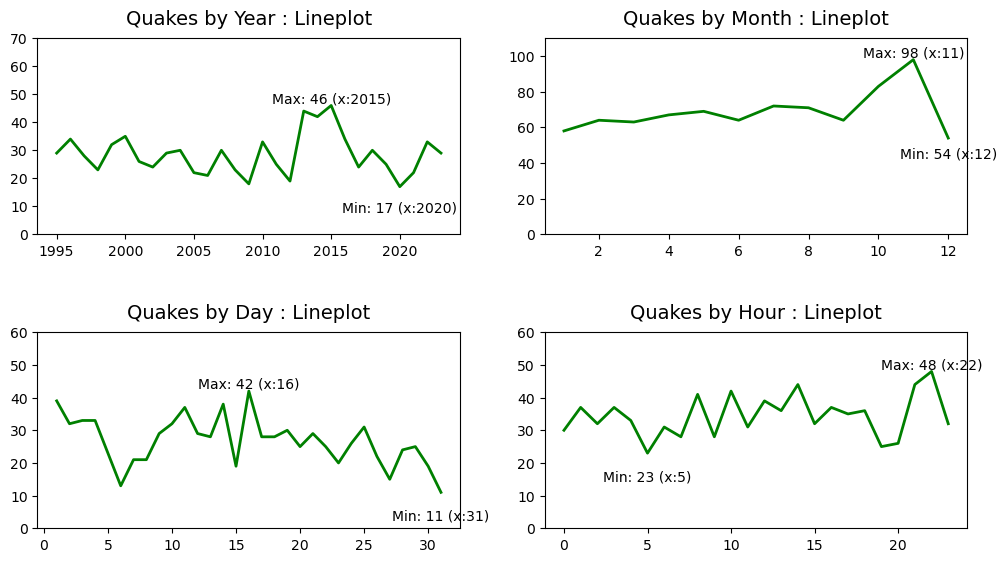

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(12, 14))

# Function to annotate highest and lowest counts and their corresponding times on the line plot
def annotate_highest_lowest(data_series):
    max_val = data_series.max()
    min_val = data_series.min()
    max_idx = data_series.idxmax()
    min_idx = data_series.idxmin()
    plt.text(max_idx, max_val, f'Max: {max_val} (x:{max_idx})', fontsize=10, va='bottom', ha='center')
    plt.text(min_idx, min_val - 5, f'Min: {min_val} (x:{min_idx})', fontsize=10, va='top', ha='center')

# plot the relationship between earthquakes and year
plt.subplot(421)
plt.title('Quakes by Year : Lineplot', pad=10, fontsize=14)
sns.lineplot(data=dff['Year'].value_counts().sort_values(), color='g', linewidth=2)
annotate_highest_lowest(dff['Year'].value_counts())
plt.ylim(0, 70), plt.ylabel(None), plt.xlabel(None)

# plot the relationship between earthquakes and month
plt.subplot(422)
plt.title('Quakes by Month : Lineplot', pad=10, fontsize=14)
sns.lineplot(data=dff['Month'].value_counts().sort_values(), color='g', linewidth=2)
annotate_highest_lowest(dff['Month'].value_counts())
plt.ylim(0, 110), plt.ylabel(None), plt.xlabel(None)

# plot the relationship between earthquakes and day
plt.subplot(423)
plt.title('Quakes by Day : Lineplot', pad=10, fontsize=14)
sns.lineplot(data=dff['Day'].value_counts().sort_values(), color='g', linewidth=2)
annotate_highest_lowest(dff['Day'].value_counts())
plt.ylim(0, 60), plt.ylabel(None), plt.xlabel(None)

# plot the relationship between earthquakes and hours
plt.subplot(424)
plt.title('Quakes by Hour : Lineplot', pad=10, fontsize=14)
sns.lineplot(data=dff['Hour'].value_counts().sort_values(), color='g', linewidth=2)
annotate_highest_lowest(dff['Hour'].value_counts())
plt.ylim(0, 60), plt.ylabel(None), plt.xlabel(None)

plt.subplots_adjust(hspace=0.5)
plt.show()


From the plot, we can observer that

1.   The number of earthquakes events was fairly high in **2013, 2014 & 2015**.
2.   **November** was the month when most earthquakes have occured and **December** is lowest month that earthquakes have occured
3.   Earthquakes occur most frequently on **16** and least frequently on **31**.
4.   By hour of the day, occurence of earthquakes is lowest at **5 a.m.** **(early morning)**, whereas it is highest at **10 p.m.** **(night time)**.








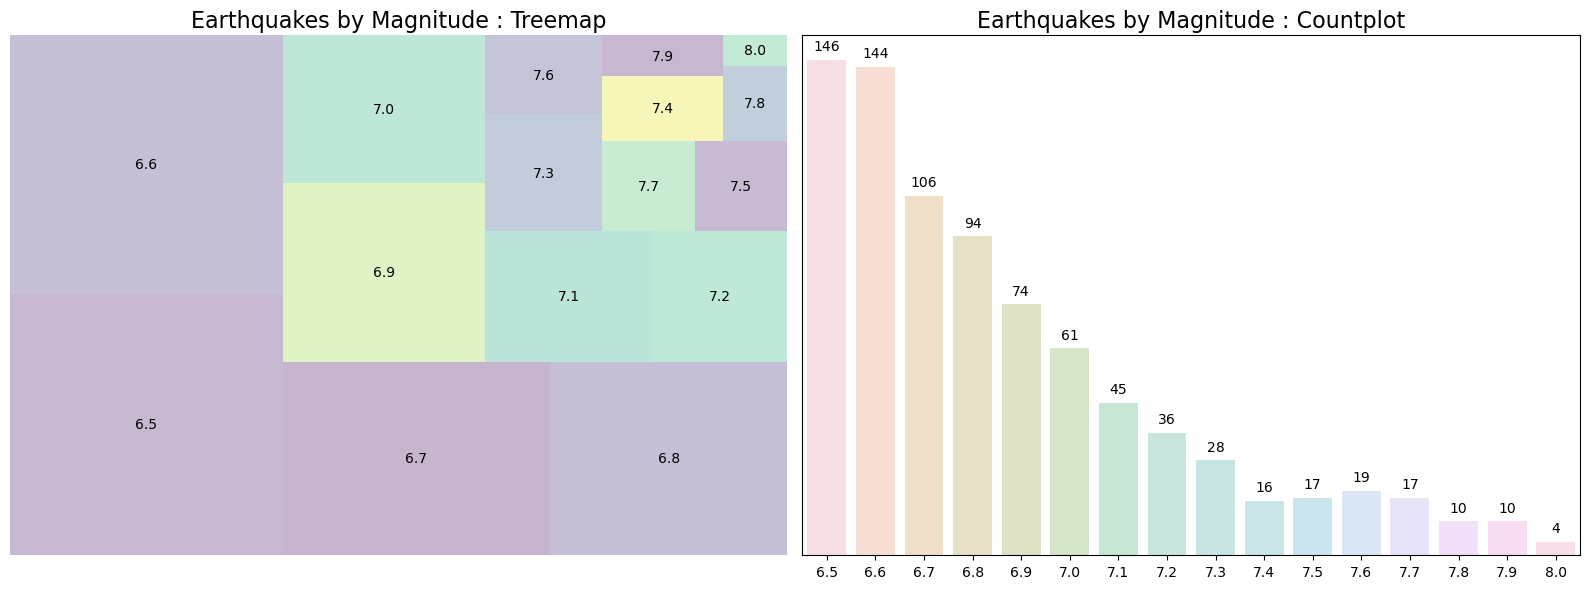

In [57]:
# plot the number of earthquakes magnitude occur with treemap & countplot
plt.subplots(figsize=(16,6))

plt.subplot(1,2,1)
plt.title('Earthquakes by Magnitude : Treemap', fontsize=16)
sizes = df['magnitude'].value_counts().values.tolist()
labels = df['magnitude'].value_counts().index.tolist()
squarify.plot(sizes=sizes, label=labels, alpha=0.3)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Earthquakes by Magnitude : Countplot', fontsize=16)
ax = sns.countplot(x='magnitude', data=df, alpha=0.3)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+ p.get_width()/2, p.get_height() + 2), ha='center', va='bottom')
plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.tight_layout()
plt.show()



*   **6.5 magnitude** has been recorded in highest number of events, followed by 6.6, 6.7, 6.8 6.9, 7.0, and so on.




(([], []), Text(0, 0.5, ''), Text(0.5, 0, ''))

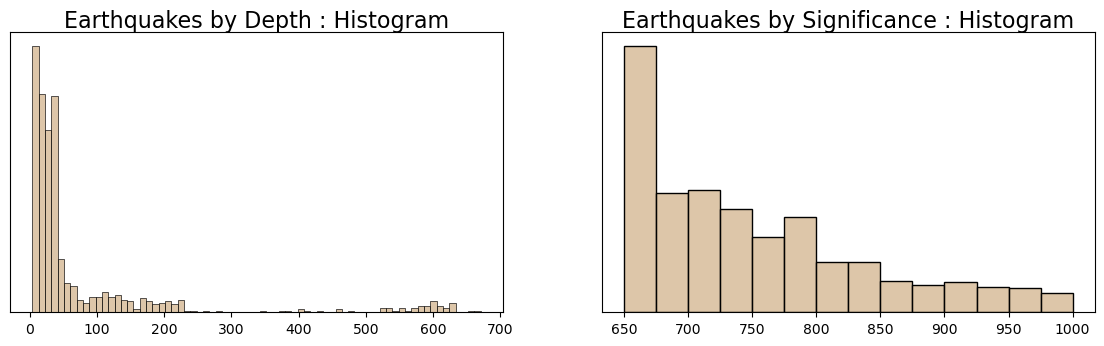

In [58]:
plt.subplots(figsize=(14,8))

# plot the relationship between earthquake occur and depth
plt.subplot(2,2,1)
plt.title('Earthquakes by Depth : Histogram', pad=1, fontsize=16)
sns.histplot(df['depth'], color="#D2B48C", kde_kws={'linewidth':1,'color':'b'})
plt.yticks([]), plt.ylabel(None), plt.xlabel(None)

# plot the relationship between earthquake occur and significance(sig)
plt.subplot(2,2,2)
plt.title('Earthquakes by Significance : Histogram', pad=1, fontsize=16)
sns.histplot(df['sig'], color="#D2B48C", kde_kws={'linewidth':1,'color':'b'})
plt.yticks([]), plt.ylabel(None), plt.xlabel(None)


.

*   Most earthquakes have occured at depths below **60** points. Median depth of all quakes is around **31**.
*   In terms of significance, most earthquakes have significance below **799**. Median significance appears at **732** .



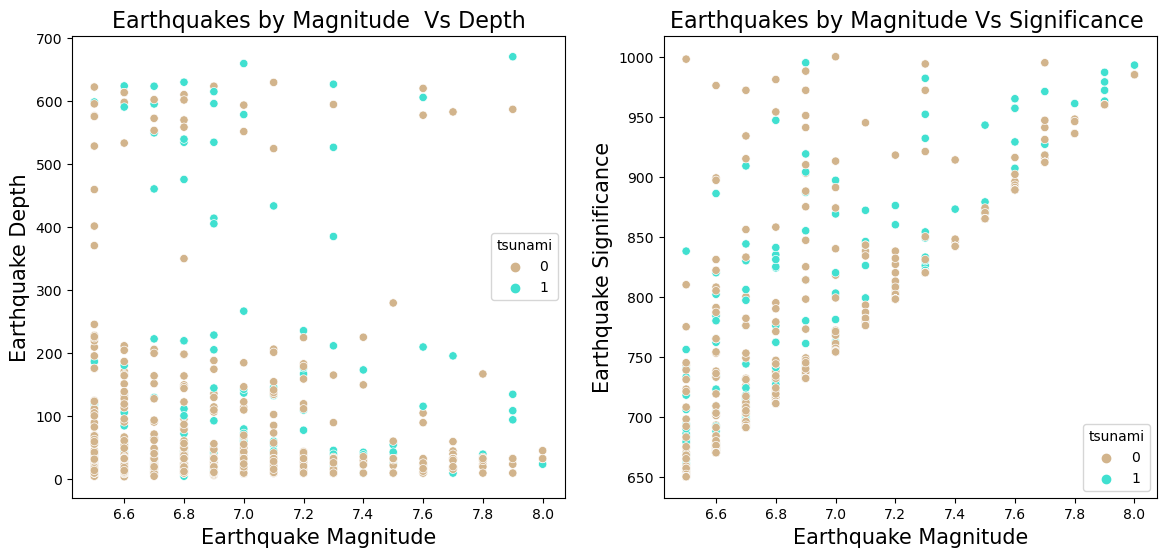

In [59]:
plt.subplots(figsize=(14,6))
my_pal = ('#D2B48C','#40E0D0')

# plot the relationship between earthquake magnitude and depth
plt.subplot(1,2,1)
plt.title('Earthquakes by Magnitude  Vs Depth',fontsize=16)
sns.scatterplot(data=df, x='magnitude', y='depth', hue='tsunami', palette=my_pal)
plt.ylabel('Earthquake Depth', fontsize=15)
plt.xlabel('Earthquake Magnitude', fontsize=15)

# plot the relationship between earthquake magnitude and significance(sig)
plt.subplot(1,2,2)
plt.title('Earthquakes by Magnitude Vs Significance ',fontsize=16)
sns.scatterplot(data=df, x='magnitude', y='sig', hue='tsunami', palette=my_pal)
plt.ylabel('Earthquake Significance', fontsize=15)
plt.xlabel('Earthquake Magnitude', fontsize=15)

plt.show()




*  There is not much correlation between earthquake magnitude and depth, and the tsunami occurence.
*   However, there appears to be a certain degree of correlation between earthquake magnitude and earthquake significance.



In [60]:
# visualize the relationship between magnitude & significance(sig) & tsunami Occurence
fig = px.scatter(df.assign(tsunami=df["tsunami"].astype(str)),
                 x='magnitude',
                 y='sig',
                 color='tsunami',
                 color_discrete_sequence=['#F0F600', '#D81159'],
                 trendline='ols',
                 trendline_scope="trace")

fig.update_layout(
    title='Magnitude and Impact Correlation',
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)

fig.show()


*   we can see that a earthquake that is followed by a tsunami is usually more destructive than it's counterpart.







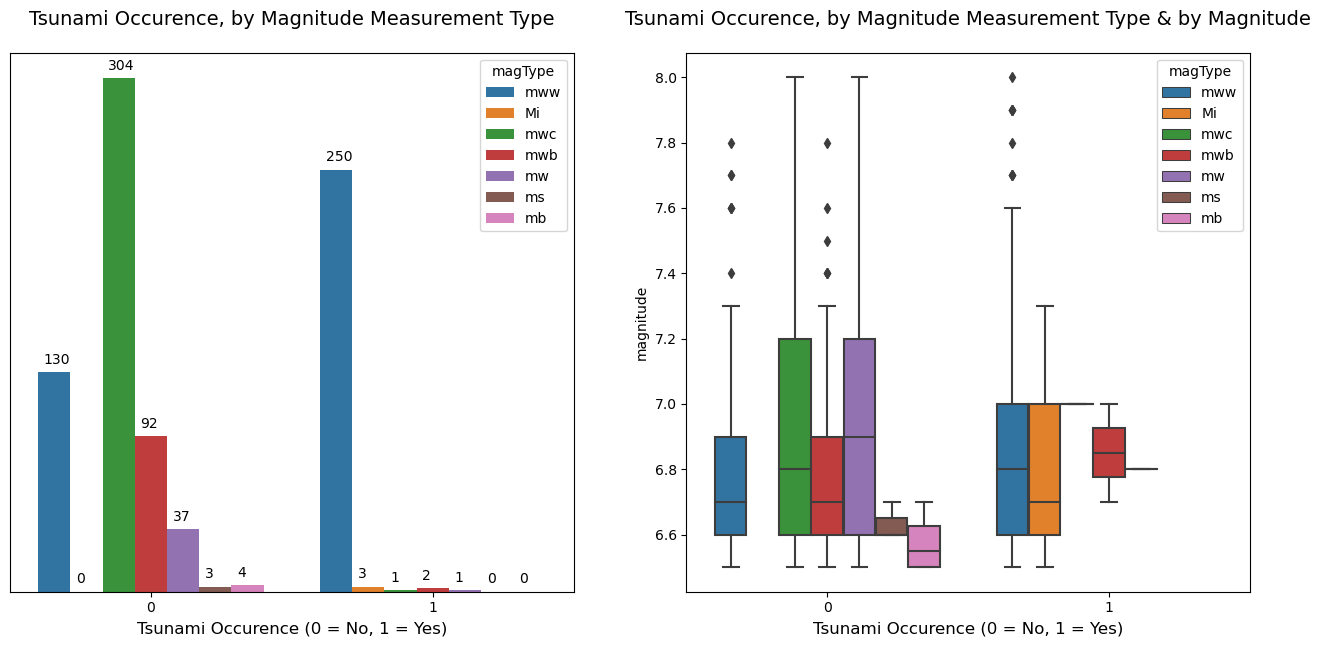

In [61]:
plt.figure(figsize=(16,7))

# plot the Tsunami Occurence by Magnitude Measurement Type(mmt)
plt.subplot(1,2,1)
plt.title('Tsunami Occurence, by Magnitude Measurement Type', pad=20, fontsize=14)
ax = sns.countplot(data=df, x='tsunami', hue='magType')

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.02, p.get_height()+5))
plt.ylabel(None), plt.yticks([])
plt.xlabel('Tsunami Occurence (0 = No, 1 = Yes)',fontsize=12)


plt.subplot(1,2,2)
plt.title('Tsunami Occurence, by Magnitude Measurement Type & by Magnitude', pad=20, fontsize=14)
sns.boxplot(data=df, x="tsunami", y="magnitude", hue="magType")
plt.xlabel('Tsunami Occurence (0 = No, 1 = Yes)',fontsize=12)

plt.show()




*   For quakes occuring in oceans, mww is the widely used measurement type.
*   On the other hand, mwc is the preferred measurement type for quakes occuring on land.



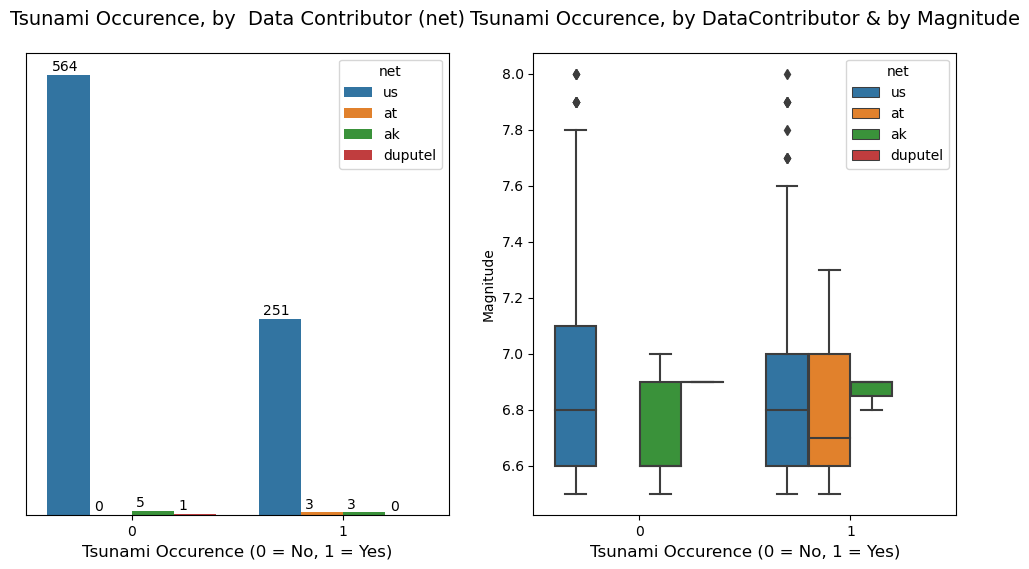

In [62]:
plt.figure(figsize=(12,6))

# plot the Tsunami Occurence by  Data Contributor (net)
plt.subplot(1,2,1)
plt.title('Tsunami Occurence, by  Data Contributor (net)', pad=20, fontsize=14)
ax = sns.countplot(x='tsunami', hue='net', data=df)

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.02, p.get_height()+5))
plt.ylabel(None), plt.yticks([])
plt.xlabel('Tsunami Occurence (0 = No, 1 = Yes)',fontsize=12)

plt.subplot(1,2,2)
plt.title('Tsunami Occurence, by DataContributor & by Magnitude', pad=20, fontsize=14)
sns.boxplot(data=df, x="tsunami", y="magnitude", hue="net")
plt.ylabel('Magnitude')
plt.xlabel('Tsunami Occurence (0 = No, 1 = Yes)', fontsize=12)

plt.show()

*   For both, tsunami and non-tsunami events, us represents the most preferred data contributor.




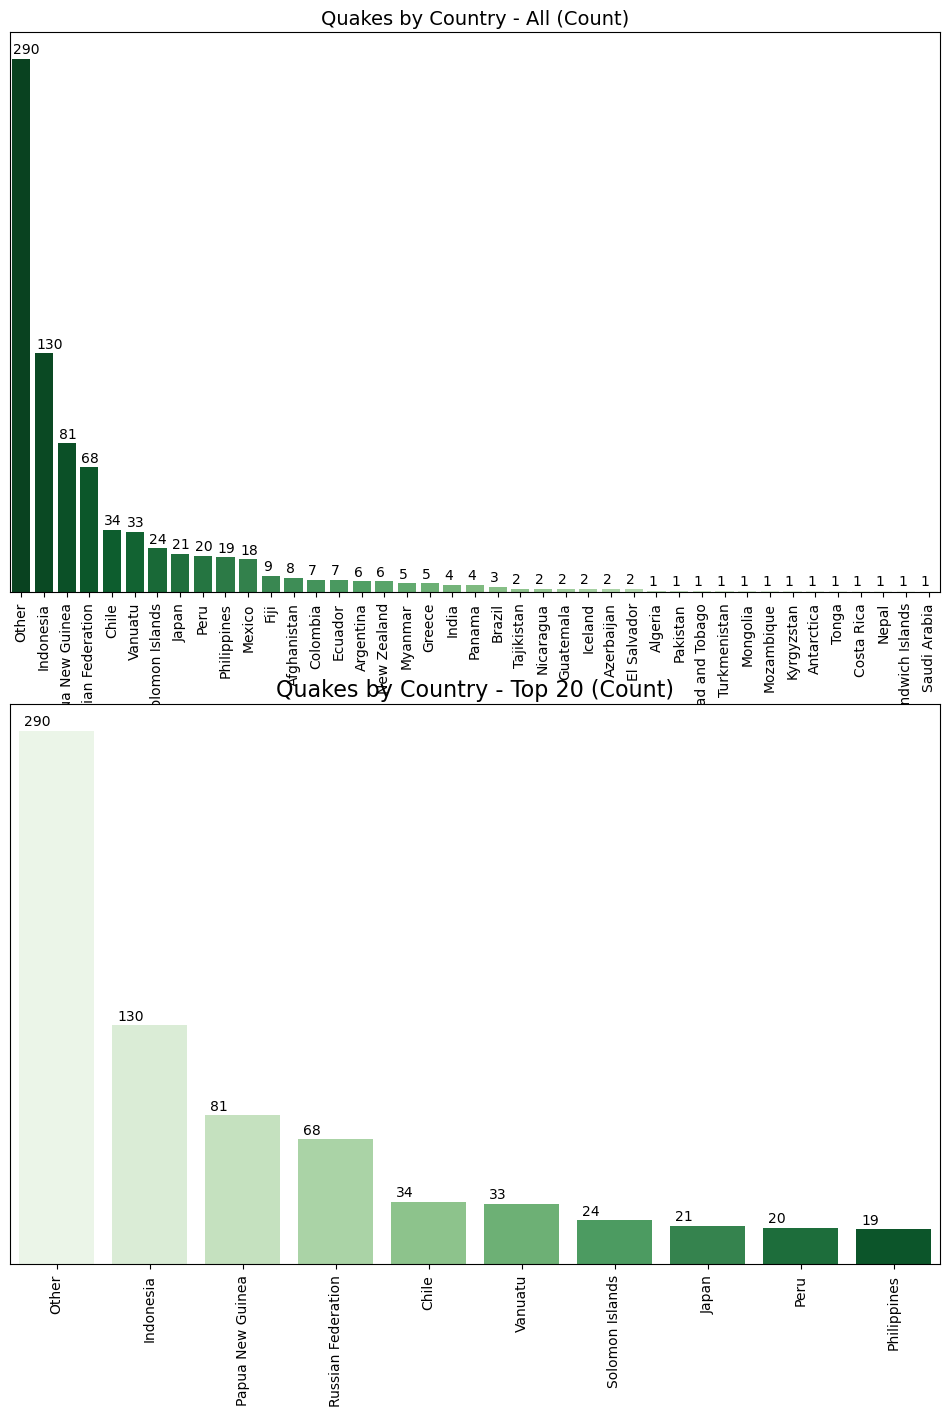

In [63]:
plt.subplots(figsize=(12,16))

# Plot a countplot to visualize earthquakes by country
plt.subplot(211)
plt.title('Quakes by Country - All (Count)', fontsize=14)
ax = sns.countplot(x=df['country'], palette='Greens_r', alpha=1, order=df['country'].value_counts().index)

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+3))

plt.xticks(rotation=90), plt.xlabel(None), plt.ylabel(None), plt.yticks([])

# Plot a countplot to visualize earthquakes by country for top 20 countries
plt.subplot(212)
plt.title('Quakes by Country - Top 20 (Count)', fontsize=16)
ax = sns.countplot(x=df['country'], palette='Greens', alpha=1, order=df['country'].value_counts().head(10).index)

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+3))

plt.xticks(rotation=90), plt.xlabel(None), plt.ylabel(None), plt.yticks([])

plt.show()

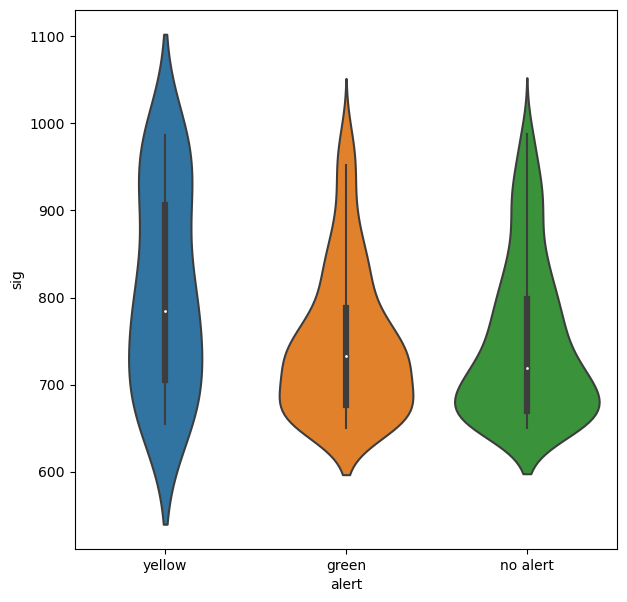

In [64]:
# plot the relationship between alert and significance(sig)
plt.figure(figsize=(7, 7))
sns.violinplot(x="alert", y="sig", data=df)
plt.show()

In [65]:

# Adding year column and creating Other location ('minor activity countries')
ddd = df.copy()
ddd['location'] = ddd['location'].str.split(', ').str[-1]
s = ddd['location'].value_counts().sort_values(ascending=False).reset_index()
top_15 = s.iloc[:15, 0].to_list()
ddd['year'] = pd.to_datetime(ddd['date_time']).dt.year
ddd['location'] = ddd['location'].apply(lambda x: 'Other' if x not in top_15 else x)

time = ddd.groupby(['location', 'year']).agg('count').reset_index()[['location', 'year', 'title']]
to_print = ['World', 'Indonesia', 'Minor Activity Countries', 'Japan', 'Papua New Guinea'] # columns to be printed

# Contains all years from 1995 - 2023
all_years = [x for x in range(1995, 2024)]

# Creating Indonesia and Other columns
indonesia = time[time['location'] == 'Indonesia'].set_index('year')
other = time[time['location'] == 'Other'].set_index('year')
japan = time[time['location'] == 'Japan'].set_index('year').reindex(all_years, fill_value=0)
papua = time[time['location'] == 'Papua New Guinea'].set_index('year').reindex(all_years, fill_value=0)

world = ddd.groupby('year').agg('count')[['title']]
world['idn'] = indonesia['title']
world['oth'] = other['title']
world['jpn'] = japan['title']
world['png'] = papua['title']

world.columns = to_print
world = world.reset_index()

# Plot the Number of tremors by year
fig1 = px.line(world, x='year', y=to_print,
               title='Number of tremors by year (World, Indonesia, Japan, Papue New Guinea, and Minor Activity Countries)')

fig1.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=False, title='Year'),
    yaxis=dict(showgrid=False, title='Number of Tremors')
)


line_colors = ['#00EEEE', '#FF3030', '#FB8B24', '#E2CFEA', '#FFEC8B']
for i, color in enumerate(line_colors):
    fig1.update_traces(selector=dict(name=to_print[i]), line=dict(color=color))

fig1.show()



*   The three main active countries, Indonesia, Papua New Guinea, and Japan, are registering low seismic activity since 2012, in comparison with their most active period from 2000 to 2011
*   From 2012 to 2023 the World had a average of 40 tremors per year, in contrast with the period from 1995 to 2011 where there were an average of 30 tremor observations by year. This trend is also visualized in the Minor Activity Countries, showing the influece this low seismic active countries had on the rising of tremor occurrences on Earth since 2012.
*   The periods of greater tectonic activity in each of the most affected countries, coincide with great tremors that occur on that year. Japan 2011 Tōhoku earthquake, Indonesia 2004 Indian Ocean earthquake and 2007 Sumatra earthquakes, and Papua New Guinea 2000 New Ireland earthquakes.



In [66]:
fd1 = df.copy()
to_print = ['cdi','mmi','magnitude']

# plot the Relationship between cdi & mmi & magnitude
fig1 = px.line(fd1, x='date_time', y=to_print,
               title='Relationship between cdi & mmi & magnitude')

for column in ['cdi', 'mmi', 'magnitude']:
    fig2.add_trace(go.Scatter(x=fd1['date_time'], y=fd1[column], mode='lines', name=column))
fig1.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(
        showgrid=False,
        title='Year',
        tickmode='auto',
        tickformat='%Y',
        dtick='M60',
    ),
    yaxis=dict(showgrid=False, title='Number')
)

fig1.show()


**cdi:** The maximum reported intensity for the event range

**mmi:** The maximum estimated instrumental intensity for the event


*   It is clear that there have been more earthquake reports since 2004.



In [67]:
# View the correlation matrix of cdi & mmi & magnitude
time_slots = [
    ('1995-05-05', '2000-01-01'),
    ('2000-01-02', '2005-01-01'),
    ('2005-01-02', '2010-01-01'),
    ('2010-01-02', '2015-01-01'),
    ('2015-01-02', '2020-01-01'),
    ('2020-01-02', '2024-01-01')
]

for i, (start_date, end_date) in enumerate(time_slots, start=1):
    subset = fd1[(fd1['date_time'] >= start_date) & (fd1['date_time'] < end_date)]
    correlation_matrix = subset[['cdi', 'mmi', 'magnitude']].corr()
    print(f"Correlation Matrix for Time Slot {i} ({start_date} - {end_date}):")
    print(correlation_matrix)
    print()

fig2 = go.Figure()

Correlation Matrix for Time Slot 1 (1995-05-05 - 2000-01-01):
           cdi       mmi  magnitude
cdi        NaN       NaN        NaN
mmi        NaN  1.000000   0.308096
magnitude  NaN  0.308096   1.000000

Correlation Matrix for Time Slot 2 (2000-01-02 - 2005-01-01):
                cdi       mmi  magnitude
cdi        1.000000 -0.059725   0.023105
mmi       -0.059725  1.000000   0.187181
magnitude  0.023105  0.187181   1.000000

Correlation Matrix for Time Slot 3 (2005-01-02 - 2010-01-01):
                cdi       mmi  magnitude
cdi        1.000000  0.077714  -0.006869
mmi        0.077714  1.000000   0.083851
magnitude -0.006869  0.083851   1.000000

Correlation Matrix for Time Slot 4 (2010-01-02 - 2015-01-01):
                cdi       mmi  magnitude
cdi        1.000000  0.237428   0.122237
mmi        0.237428  1.000000   0.169204
magnitude  0.122237  0.169204   1.000000

Correlation Matrix for Time Slot 5 (2015-01-02 - 2020-01-01):
                cdi       mmi  magnitude
cdi      



*   From the matrix, we can see that the **correlation** between **cdi** and **mmi** is **increasing** by years.




In [68]:
dfor = pd.read_csv("earthquake_1995-2023.csv")
# Define the dataframe 'dcom' with the desired columns
dcom = pd.DataFrame({'mag': df['magnitude'], 'omag': dfor['magnitude'],'cdi': df['cdi'], 'ocdi': dfor['cdi']
                     ,'mmi': df['mmi'], 'ommi': dfor['mmi'],'tsu': df['tsunami'], 'otsu': dfor['tsunami']
                     ,'sig': df['sig'], 'osig': dfor['sig'],'dmin': df['dmin'], 'odmin': dfor['dmin']
                     ,'gap': df['gap'], 'ogap': dfor['gap'],'dep': df['depth'], 'odep': dfor['depth']})



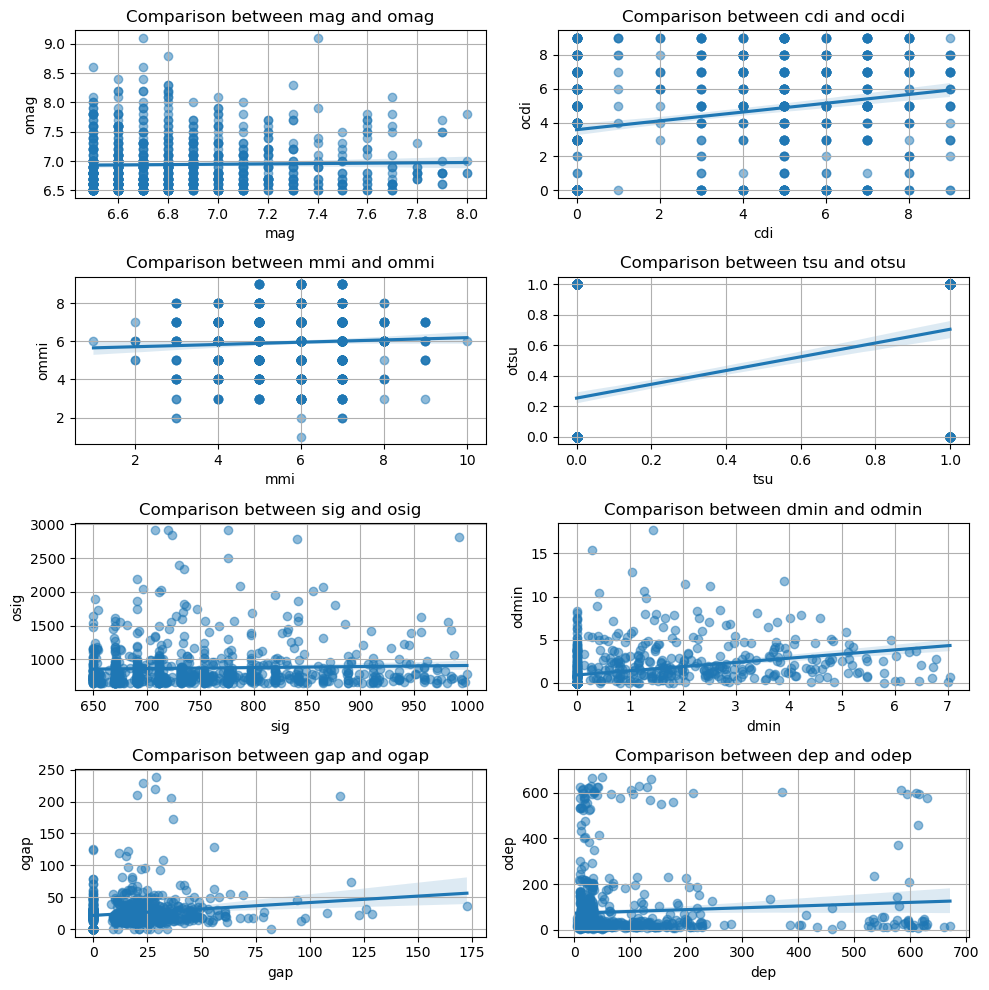

In [69]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 2, 1)
sns.regplot(x='mag', y='omag', data=dcom, scatter_kws={'alpha': 0.5})
plt.title('Comparison between mag and omag')
plt.xlabel('mag')
plt.ylabel('omag')
plt.grid(True)

plt.subplot(4, 2, 2)
sns.regplot(x='cdi', y='ocdi', data=dcom, scatter_kws={'alpha': 0.5})
plt.title('Comparison between cdi and ocdi')
plt.xlabel('cdi')
plt.ylabel('ocdi')
plt.grid(True)

plt.subplot(4, 2, 3)
sns.regplot(x='mmi', y='ommi', data=dcom, scatter_kws={'alpha': 0.5})
plt.title('Comparison between mmi and ommi')
plt.xlabel('mmi')
plt.ylabel('ommi')
plt.grid(True)

plt.subplot(4, 2, 4)
sns.regplot(x='tsu', y='otsu', data=dcom, scatter_kws={'alpha': 0.5})
plt.title('Comparison between tsu and otsu')
plt.xlabel('tsu')
plt.ylabel('otsu')
plt.grid(True)

plt.subplot(4, 2, 5)
sns.regplot(x='sig', y='osig', data=dcom, scatter_kws={'alpha': 0.5})
plt.title('Comparison between sig and osig')
plt.xlabel('sig')
plt.ylabel('osig')
plt.grid(True)

plt.subplot(4, 2, 6)
sns.regplot(x='dmin', y='odmin', data=dcom, scatter_kws={'alpha': 0.5})
plt.title('Comparison between dmin and odmin')
plt.xlabel('dmin')
plt.ylabel('odmin')
plt.grid(True)

plt.subplot(4, 2, 7)
sns.regplot(x='gap', y='ogap', data=dcom, scatter_kws={'alpha': 0.5})
plt.title('Comparison between gap and ogap')
plt.xlabel('gap')
plt.ylabel('ogap')
plt.grid(True)

plt.subplot(4, 2, 8)
sns.regplot(x='dep', y='odep', data=dcom, scatter_kws={'alpha': 0.5})
plt.title('Comparison between dep and odep')
plt.xlabel('dep')
plt.ylabel('odep')
plt.grid(True)

plt.tight_layout()
plt.show()


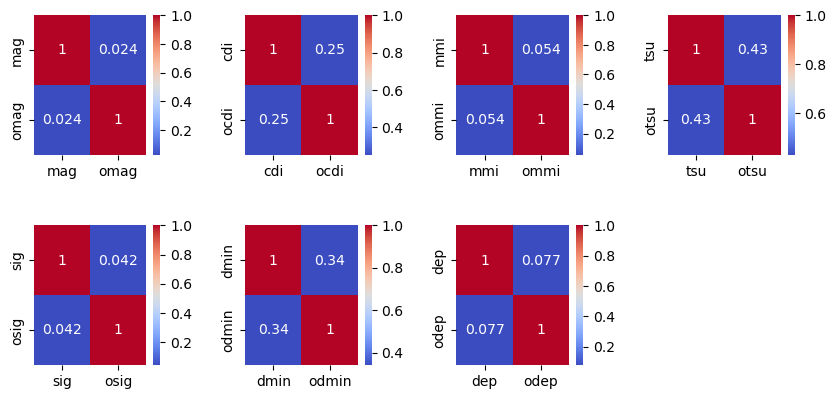

In [70]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 4, 1)
corr_matrix = dcom[['mag', 'omag']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


plt.subplot(4, 4, 2)
corr_matrix = dcom[['cdi', 'ocdi']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


plt.subplot(4, 4, 3)
corr_matrix = dcom[['mmi', 'ommi']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


plt.subplot(4, 4, 4)
corr_matrix = dcom[['tsu', 'otsu']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.subplot(4, 4, 5)
corr_matrix = dcom[['sig', 'osig']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.subplot(4, 4, 6)
corr_matrix = dcom[['dmin', 'odmin']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.subplot(4, 4, 7)
corr_matrix = dcom[['gap', 'ogap']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.subplot(4, 4, 7)
corr_matrix = dcom[['dep', 'odep']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

<br> 

# Scaling

In [71]:
clustering_data_1 = df_outliers[["magnitude", "cdi", "mmi", "tsunami", 
                                 "sig", "dmin", "gap", "depth"]]

clustering_data_2 = df_no_outliers[["magnitude", "cdi", "mmi", "tsunami", 
                                    "sig", "dmin", "gap", "depth"]]

cluster_vars = ["magnitude", "cdi", "mmi", "tsunami", 
                "sig", "dmin", "gap", "depth"]

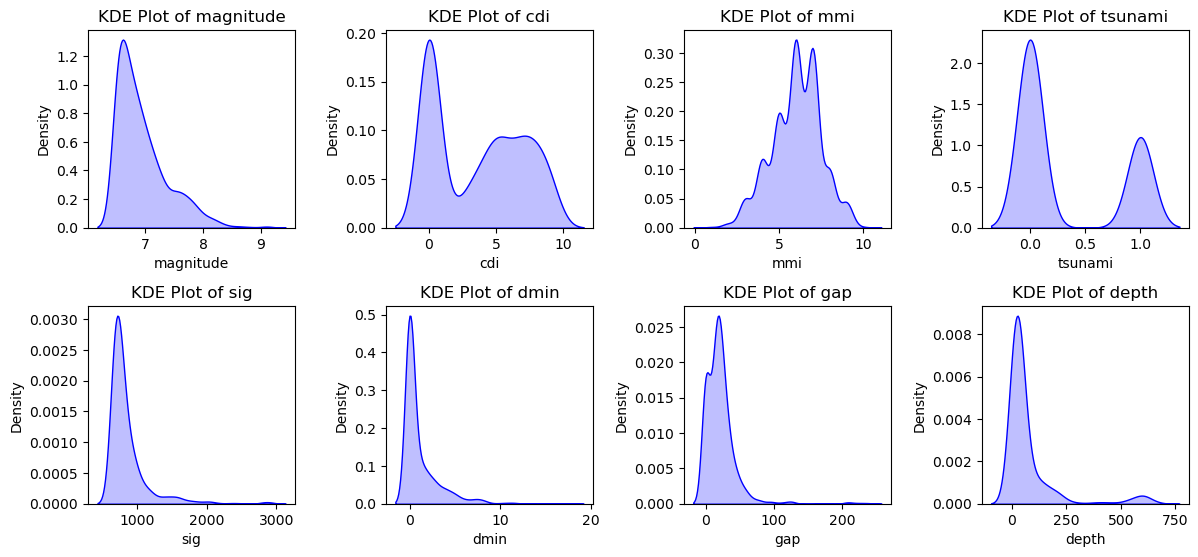

In [72]:
# Plotting KDE plots for cluster varibles in outliers dataframe
plt.figure(figsize=(12, 8))
for i, var in enumerate(cluster_vars):
    plt.subplot(3, 4, i + 1)
    sns.kdeplot(df_outliers[var], color='blue', fill=True)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.title(f'KDE Plot of {var}')

plt.tight_layout()
plt.show()

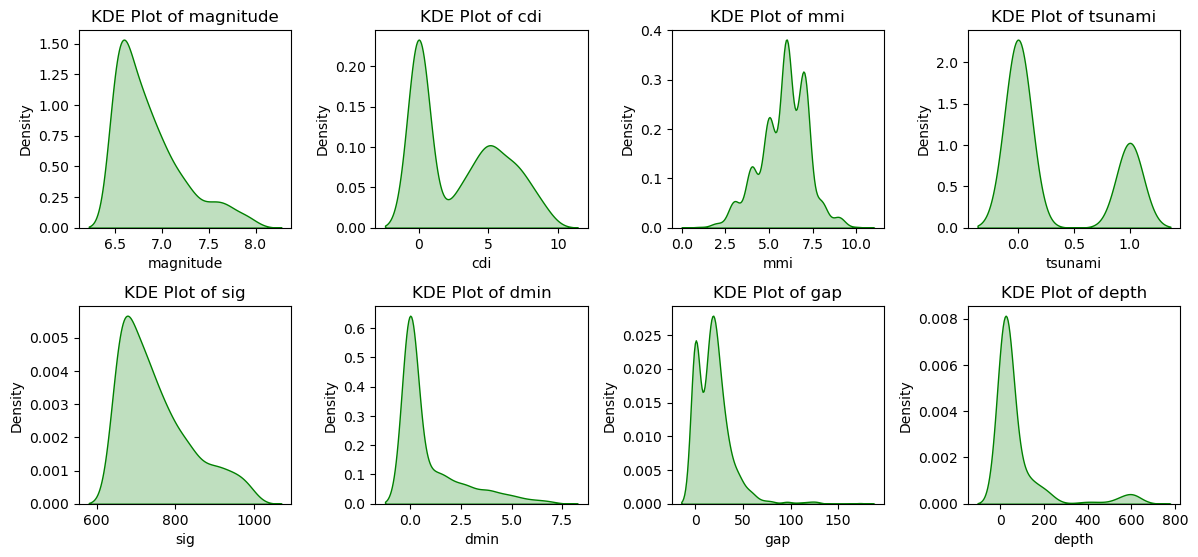

In [73]:
# Plotting KDE plots for cluster varibles in no outliers dataframe
plt.figure(figsize=(12, 8))
for i, var in enumerate(cluster_vars):
    plt.subplot(3, 4, i + 1)
    sns.kdeplot(df_no_outliers[var], color='green', fill=True)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.title(f'KDE Plot of {var}')

plt.tight_layout()
plt.show()

<br>

Use MinMaxScaler to scale the data instead of: 
1. StandardScaler 
   - Scaling technique that suitable for the dataset which follows a normal distribution (Gaussian)
   - Will not used since the KDE plot of two datasets show the cluster variables are not most in normal distrbution 
2. RobustScaler 
   - Handles outliers and skewness
   - It removes the median and scales the data according to the IQR
   - Will not used in outliers dataframe since it is used to the models that can handle outliers
   - Also will not used in no outliers dataframe because we have conclude that IQR method may not useful to the dataset in outlier remove part above 

In [74]:
# Use MinMaxScaler to scale the variables in the range of 0 and 1, inclusive
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

minmax_data_scaled_1 = clustering_data_1.copy() # contain outliers
minmax_data_scaled_2 = clustering_data_2.copy() # no outliers

In [75]:
# Scaled data that contain outliers
minmax_data_scaled_1[["magnitude", "cdi", "mmi", "tsunami", 
                "sig", "dmin", "gap", "depth"]] = minmax_scaler.fit_transform(minmax_data_scaled_1) 

minmax_data_scaled_1

magnitude       cdi       mmi  tsunami       sig      dmin       gap  \
0     0.000000  0.777778  0.333333      0.0  0.003097  0.406537  0.104603   
1     0.000000  0.888889  0.555556      0.0  0.055310  0.038462  0.167364   
2     0.038462  0.777778  0.444444      0.0  0.110177  0.092557  0.117155   
3     0.269231  0.666667  0.555556      1.0  0.092920  0.051376  0.150628   
4     0.307692  0.000000  0.444444      1.0  0.075221  0.049816  0.723013   
..         ...       ...       ...      ...       ...       ...       ...   
995   0.230769  0.000000  0.888889      0.0  0.055752  0.000000  0.000000   
996   0.461538  0.000000  0.333333      0.0  0.115929  0.000000  0.000000   
997   0.153846  0.000000  0.555556      0.0  0.036283  0.000000  0.000000   
998   0.038462  0.000000  0.888889      0.0  0.008850  0.000000  0.000000   
999   0.230769  0.000000  0.666667      0.0  0.055752  0.000000  0.000000   

        depth  
0    0.284766  
1    0.100323  
2    0.252460  
3    0.044710  
4    0.027391  
..        ...  
995  0.012423  
996  0.026193  
997  0.012722  
998  0.016913  
999  0.019907  

[1000 rows x 8 columns]

In [76]:
# Scaled data that do not contain outliers
minmax_data_scaled_2[["magnitude", "cdi", "mmi", "tsunami", 
                "sig", "dmin", "gap", "depth"]] = minmax_scaler.fit_transform(minmax_data_scaled_2)

minmax_data_scaled_2

magnitude       cdi       mmi  tsunami       sig      dmin       gap  \
0     0.000000  0.888889  0.555556      0.0  0.357143  0.096408  0.231481   
1     0.066667  0.777778  0.444444      0.0  0.711429  0.232003  0.162037   
2     0.466667  0.666667  0.555556      1.0  0.600000  0.128780  0.208333   
3     0.533333  0.000000  0.444444      1.0  0.485714  0.124869  1.000000   
4     0.066667  0.555556  0.333333      1.0  0.434286  0.348431  0.214120   
..         ...       ...       ...      ...       ...       ...       ...   
822   0.400000  0.000000  0.888889      0.0  0.360000  0.000000  0.000000   
823   0.800000  0.000000  0.333333      0.0  0.748571  0.000000  0.000000   
824   0.266667  0.000000  0.555556      0.0  0.234286  0.000000  0.000000   
825   0.066667  0.000000  0.888889      0.0  0.057143  0.000000  0.000000   
826   0.400000  0.000000  0.666667      0.0  0.360000  0.000000  0.000000   

        depth  
0    0.098299  
1    0.250778  
2    0.042560  
3    0.025202  
4    0.008701  
..        ...  
822  0.010201  
823  0.024002  
824  0.010501  
825  0.014701  
826  0.017702  

[827 rows x 8 columns]

In [77]:
minmax_data_scaled_1 = minmax_data_scaled_1.to_numpy()
minmax_data_scaled_2 = minmax_data_scaled_2.to_numpy()

<br> 

- Scaling ensures that all variables contribute equally to the clustering process
- Then, clustering algorithm will not give more weight to variables with larger scales 
- MinMaxScaler scales variables result in specified range between 0 and 1 
- MinMaxScaler preserves the shape of the original distribution while scaling the values 

<br>

# Modeling

## K-Means

### Elbow Method to find optimal number of parameter

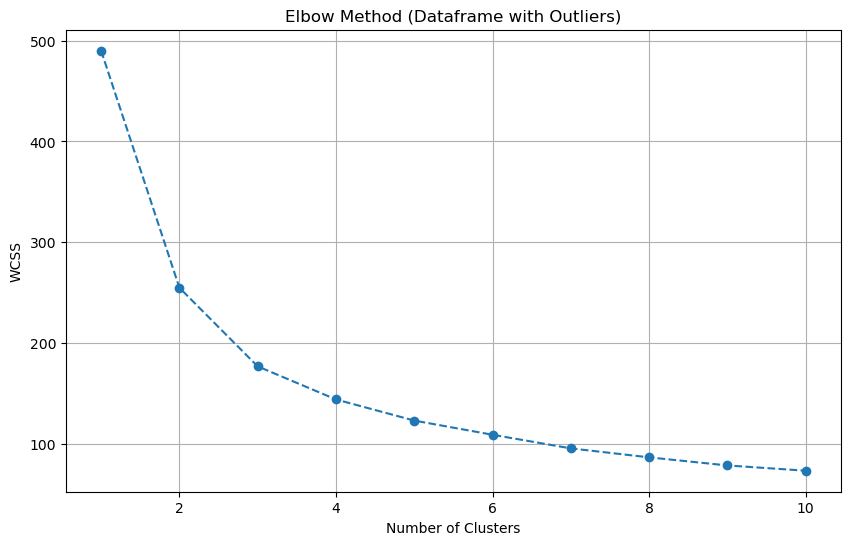

In [78]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the range of cluster numbers to test
max_clusters = 10

# Calculate WCSS for each number of clusters
wcss = []
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(minmax_data_scaled_1)  # dataframe with outliers
    wcss.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters+1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method (Dataframe with Outliers)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

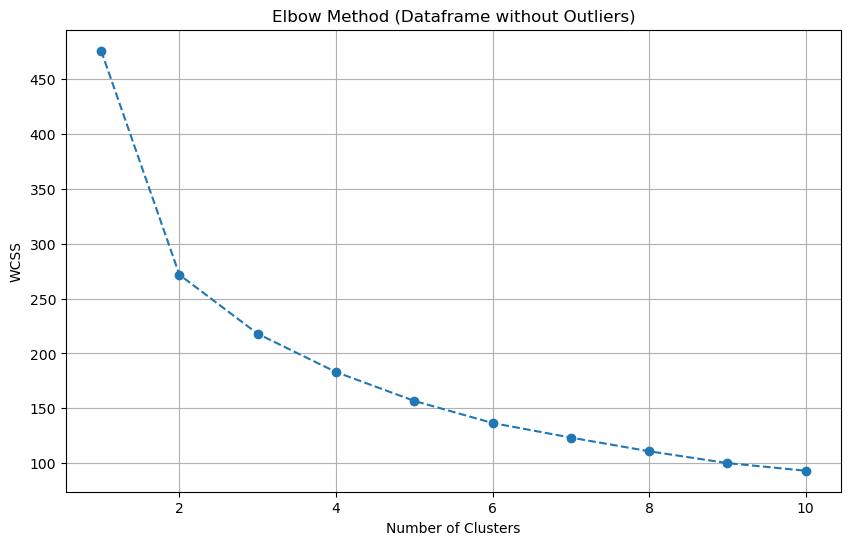

In [79]:
# Determine the range of cluster numbers to test
max_clusters = 10

# Calculate WCSS for each number of clusters
wcss = []
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(minmax_data_scaled_2)  # dataframe without outliers
    wcss.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters+1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method (Dataframe without Outliers)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

<br>

### Average Silhouette Method

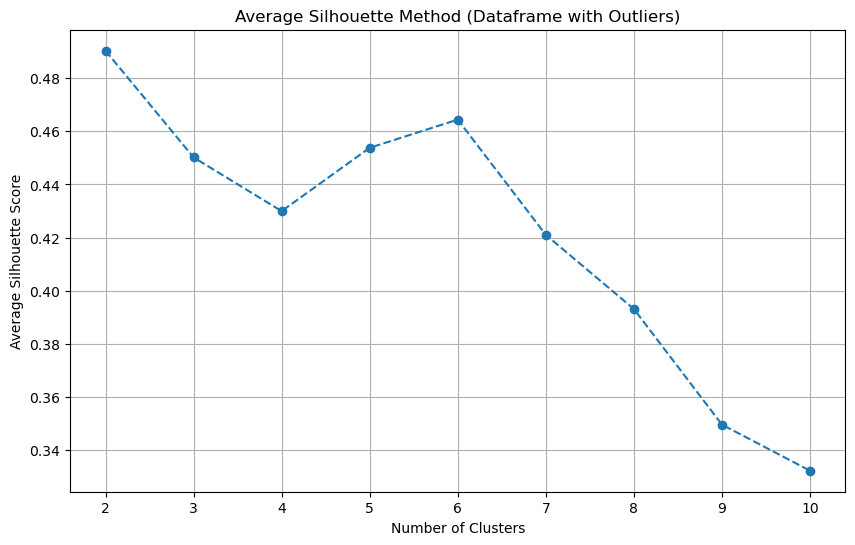

In [80]:
# The number of clusters corresponding to the highest peak as the optimal number of clusters
from sklearn.metrics import silhouette_score, silhouette_samples

# Set the range of cluster numbers to test
max_clusters = 10

# Initialize a list to store average silhouette scores
avg_silhouette_scores = []

# Fit KMeans with different number of clusters and compute silhouette scores
for i in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(minmax_data_scaled_1)  # dataframe with outliers
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(minmax_data_scaled_1, labels, metric='euclidean')  # dataframe with outliers
    avg_silhouette_scores.append(silhouette_avg)

# Plot the average silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters+1), avg_silhouette_scores, marker='o', linestyle='--')
plt.title('Average Silhouette Method (Dataframe with Outliers)')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

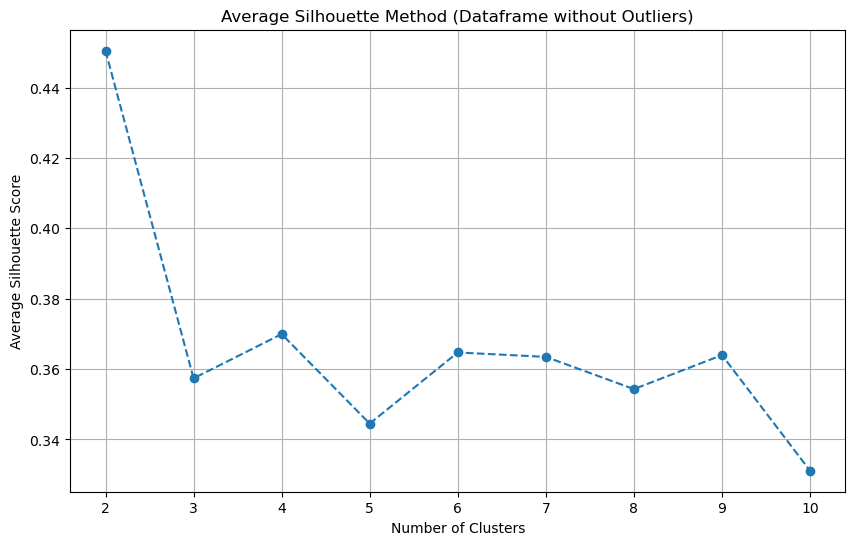

In [81]:
# Set the range of cluster numbers to test
max_clusters = 10

# Initialize a list to store average silhouette scores
avg_silhouette_scores = []

# Fit KMeans with different number of clusters and compute silhouette scores
for i in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(minmax_data_scaled_2)  # dataframe without outliers
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(minmax_data_scaled_2, labels, metric='euclidean')  # dataframe without outliers
    avg_silhouette_scores.append(silhouette_avg)

# Plot the average silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters+1), avg_silhouette_scores, marker='o', linestyle='--')
plt.title('Average Silhouette Method (Dataframe without Outliers)')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

- Elbow point in the Elbow Method will be the optimal number of cluster
- Highest peak in the Average Silhouette Method plot will be the optimal number of cluster which is 2

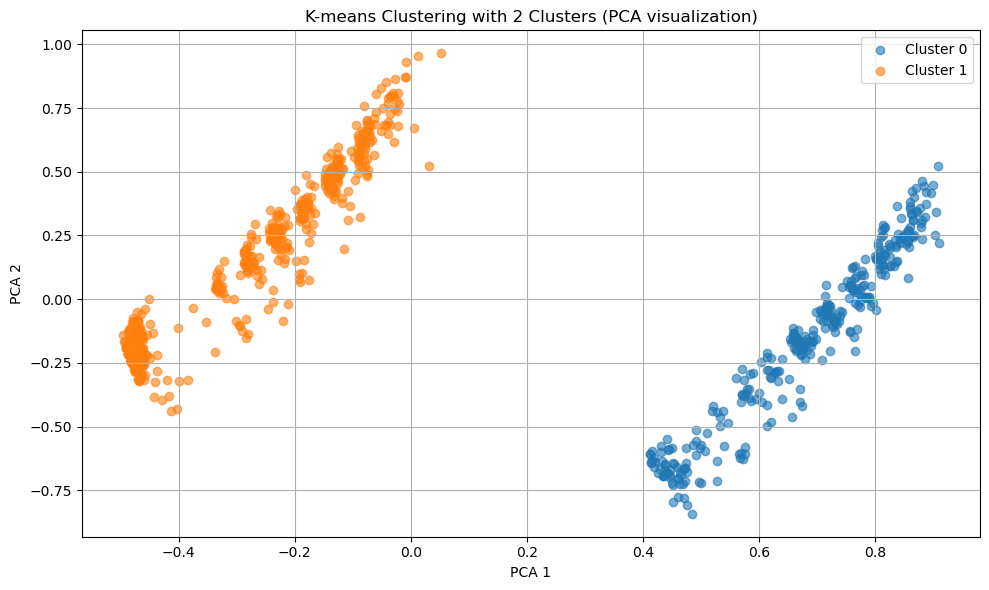

In [82]:
from sklearn.decomposition import PCA

# Cluster the data into 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
df_outliers['Cluster'] = kmeans.fit_predict(minmax_data_scaled_1)

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(minmax_data_scaled_1)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(2):
    subset = data_pca[df_outliers['Cluster'] == cluster_num]
    plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('K-means Clustering with 2 Clusters (PCA visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

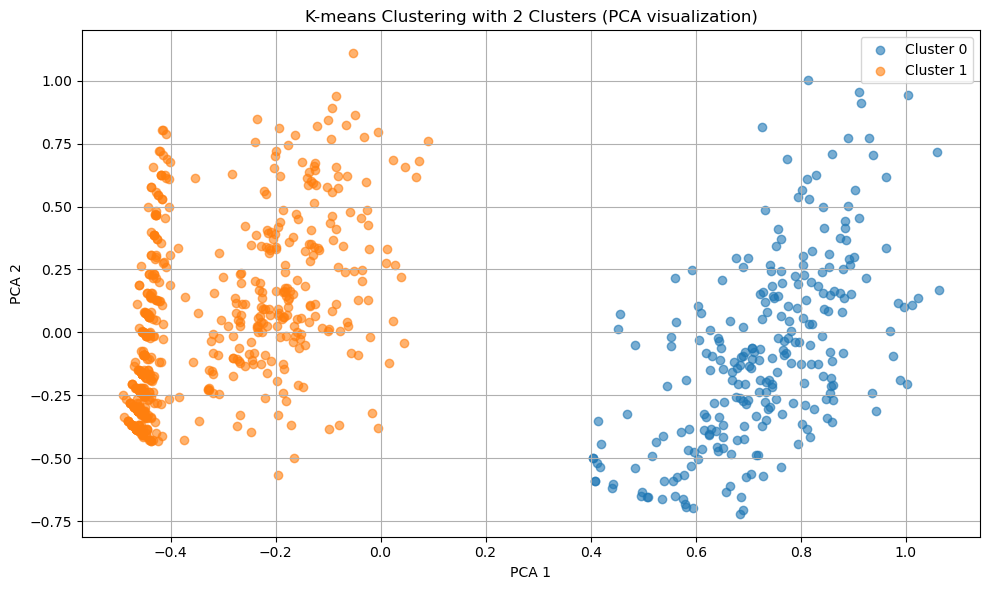

In [83]:
# NO Contains Outliers

from sklearn.decomposition import PCA

# Cluster the data into 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
df_no_outliers['Cluster'] = kmeans.fit_predict(minmax_data_scaled_2)

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(minmax_data_scaled_2)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(2):
    subset = data_pca[df_no_outliers['Cluster'] == cluster_num]
    plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('K-means Clustering with 2 Clusters (PCA visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

## Gaussian Mixture

### Elbow Method to find optimal number of parameter

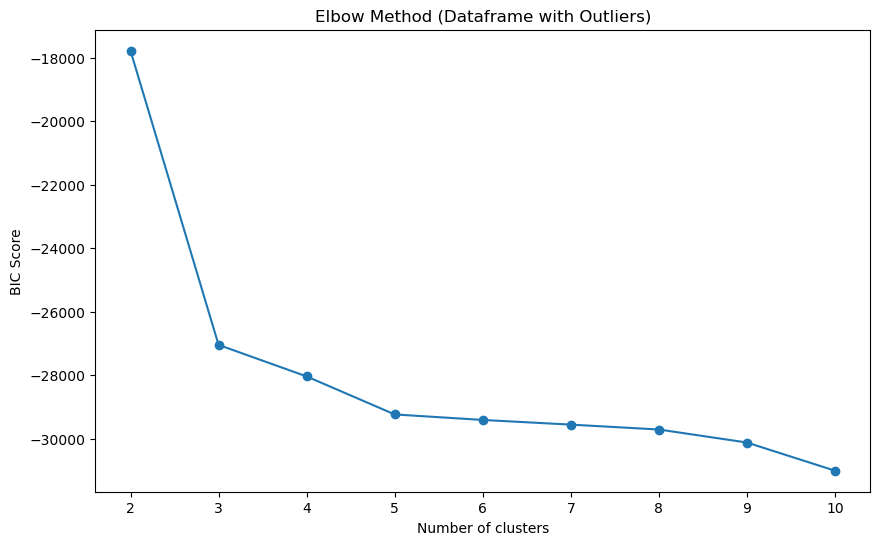

In [84]:
from sklearn.mixture import GaussianMixture

# Fit Gaussian Mixture Model for different numbers of clusters
n_clusters_range = range(2, 11)
bic_scores = []

for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(minmax_data_scaled_1)  # dataframe with outliers
    bic_scores.append(gmm.bic(minmax_data_scaled_1))  # dataframe with outliers

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, bic_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')
plt.title('Elbow Method (Dataframe with Outliers)')
plt.show()

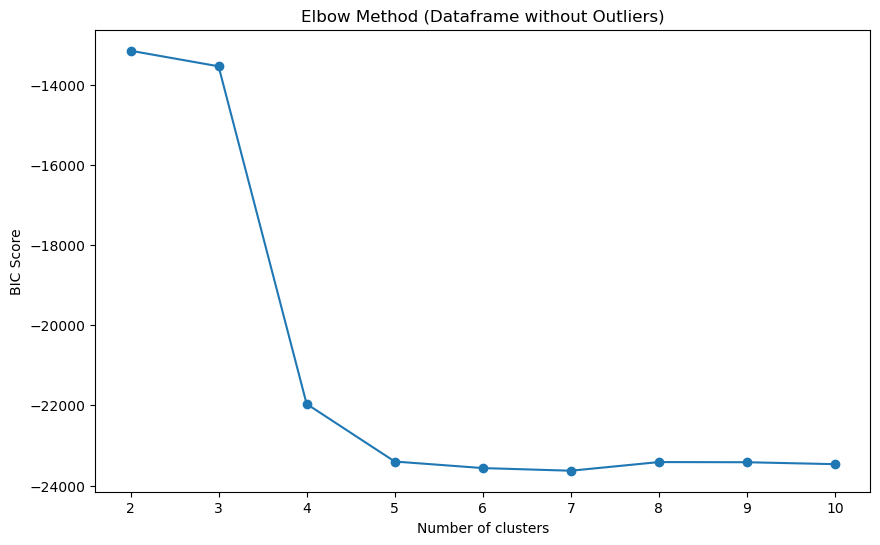

In [85]:
from sklearn.mixture import GaussianMixture

# Fit Gaussian Mixture Model for different numbers of clusters
n_clusters_range = range(2, 11)
bic_scores = []

for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(minmax_data_scaled_2)  # dataframe without outliers
    bic_scores.append(gmm.bic(minmax_data_scaled_2))  # dataframe without outliers

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, bic_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')
plt.title('Elbow Method (Dataframe without Outliers)')
plt.show()

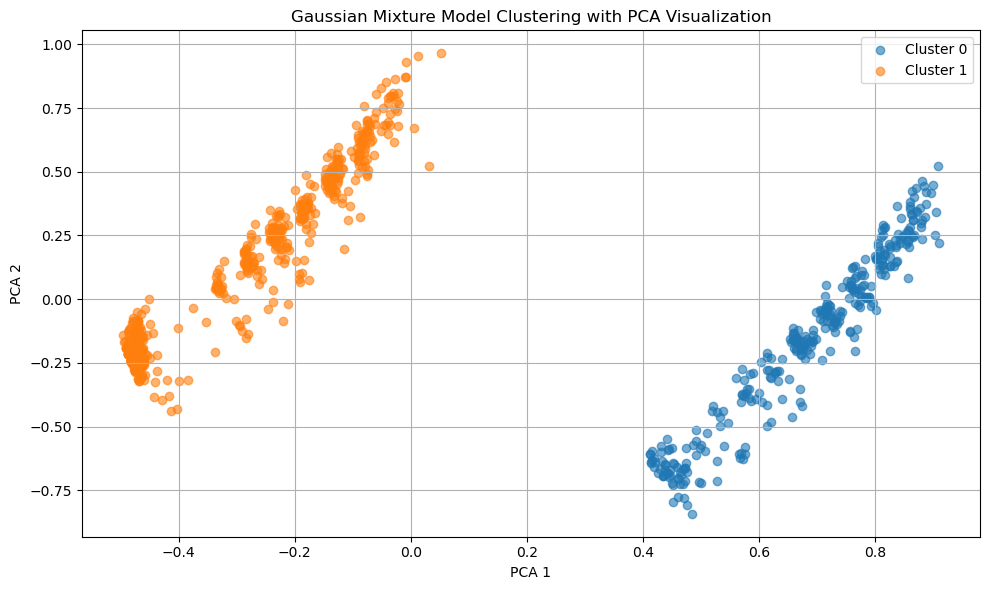

In [86]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Perform GMM clustering
gmm = GaussianMixture(n_components=2, random_state=42)
df_outliers['Cluster'] = gmm.fit_predict(minmax_data_scaled_1)

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(minmax_data_scaled_1)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(2):
    subset = data_pca[df_outliers['Cluster'] == cluster_num]
    plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('Gaussian Mixture Model Clustering with PCA Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

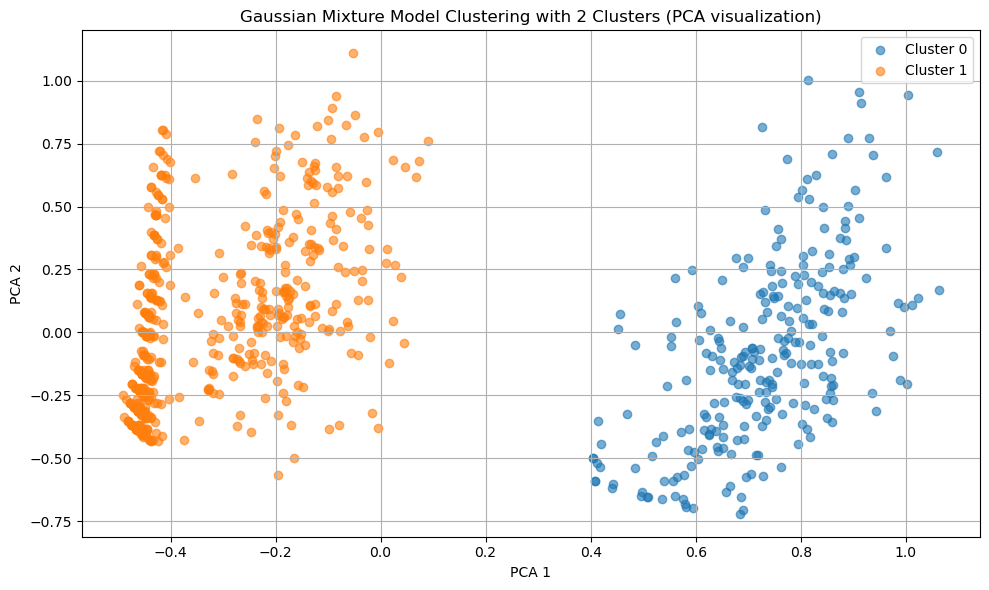

In [87]:
from sklearn.mixture import GaussianMixture

# Cluster the data into 2 clusters using Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
df_no_outliers['Cluster'] = gmm.fit_predict(minmax_data_scaled_2)

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(minmax_data_scaled_2)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(2):
    subset = data_pca[df_no_outliers['Cluster'] == cluster_num]
    plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('Gaussian Mixture Model Clustering with 2 Clusters (PCA visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

## DBSCAN

In [88]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Dataframe with Outliers

In [89]:
def grid_search_dbscan(data_scaled):
    
    # Define parameter search space
    eps_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    min_samples_values = [5, 10, 15, 20]

    best_score = -1
    best_eps = None
    best_min_samples = None

    # Grid search over parameter space
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(data_scaled)
            silhouette_avg = silhouette_score(data_scaled, cluster_labels)
            print(f"For eps={eps}, min_samples={min_samples}, silhouette score: {silhouette_avg}")
        
            # Update best parameters if silhouette score improves
            if silhouette_avg >= best_score:
                best_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

    print(f"\nBest parameters: eps={best_eps}, min_samples={best_min_samples}, silhouette score: {best_score}")
    
    return best_eps, best_min_samples

In [90]:
# Define the parameter according to the grid search function
eps, min_samples = grid_search_dbscan(minmax_data_scaled_1)

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_outliers['DBSCAN_Cluster'] = dbscan.fit_predict(minmax_data_scaled_1)

For eps=0.1, min_samples=5, silhouette score: -0.30054510800513173
For eps=0.1, min_samples=10, silhouette score: -0.14242972051739605
For eps=0.1, min_samples=15, silhouette score: -0.02125902657967628
For eps=0.1, min_samples=20, silhouette score: -0.039578283880420465
For eps=0.3, min_samples=5, silhouette score: 0.439298186285516
For eps=0.3, min_samples=10, silhouette score: 0.40372390550562953
For eps=0.3, min_samples=15, silhouette score: 0.45753915843281434
For eps=0.3, min_samples=20, silhouette score: 0.45552039932745425
For eps=0.5, min_samples=5, silhouette score: 0.4847846034009277
For eps=0.5, min_samples=10, silhouette score: 0.4847846034009277
For eps=0.5, min_samples=15, silhouette score: 0.4822430405618264
For eps=0.5, min_samples=20, silhouette score: 0.48114122252200564
For eps=0.7, min_samples=5, silhouette score: 0.48352485790537725
For eps=0.7, min_samples=10, silhouette score: 0.48352485790537725
For eps=0.7, min_samples=15, silhouette score: 0.48352485790537725

In [91]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)  
data_pca = pca.fit_transform(minmax_data_scaled_1)

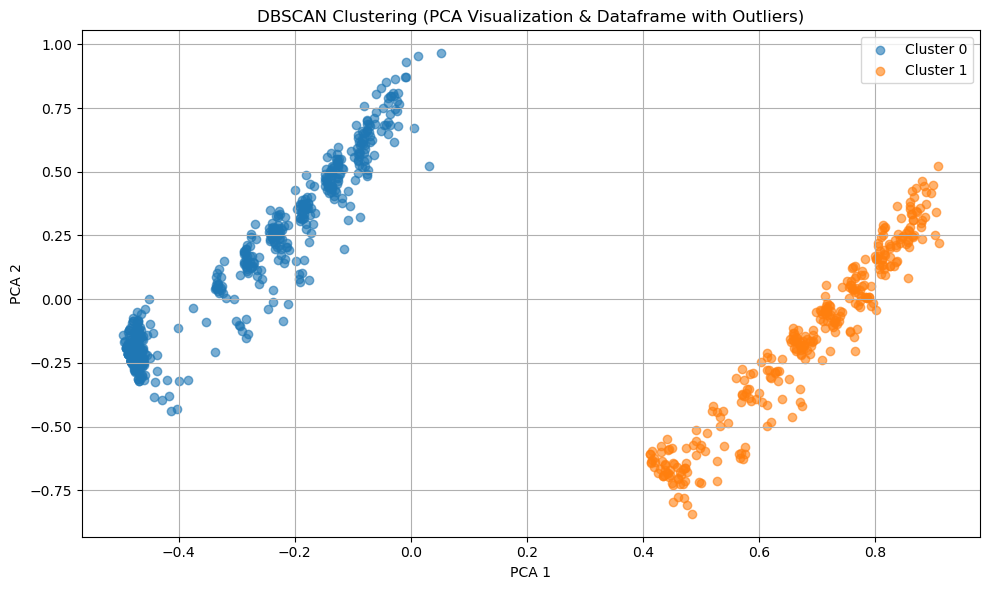

In [92]:
# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in set(df_outliers['DBSCAN_Cluster']):
    if cluster_num == -1:
        subset = data_pca[df_outliers['DBSCAN_Cluster'] == cluster_num]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Outliers", alpha=0.6, color='black')
    else:
        subset = data_pca[df_outliers['DBSCAN_Cluster'] == cluster_num]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('DBSCAN Clustering (PCA Visualization & Dataframe with Outliers)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Dataframe without Outliers

In [93]:
# Define the parameter according to the grid search function
eps, min_samples = grid_search_dbscan(minmax_data_scaled_2) 

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_no_outliers['DBSCAN_Cluster'] = dbscan.fit_predict(minmax_data_scaled_2)

For eps=0.1, min_samples=5, silhouette score: -0.23443279339187512
For eps=0.1, min_samples=10, silhouette score: -0.130202669608602
For eps=0.1, min_samples=15, silhouette score: -0.15646047188424286
For eps=0.1, min_samples=20, silhouette score: -0.1380833403739768
For eps=0.3, min_samples=5, silhouette score: 0.3302144930947942
For eps=0.3, min_samples=10, silhouette score: 0.31355256471667065
For eps=0.3, min_samples=15, silhouette score: 0.32703662279129103
For eps=0.3, min_samples=20, silhouette score: 0.2977480602530679
For eps=0.5, min_samples=5, silhouette score: 0.43325998544126065
For eps=0.5, min_samples=10, silhouette score: 0.4327622052418558
For eps=0.5, min_samples=15, silhouette score: 0.41042959534481577
For eps=0.5, min_samples=20, silhouette score: 0.44476627551166853
For eps=0.7, min_samples=5, silhouette score: 0.42886418919392216
For eps=0.7, min_samples=10, silhouette score: 0.42886418919392216
For eps=0.7, min_samples=15, silhouette score: 0.43768485869645785
F

In [94]:
# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)  
data_pca = pca.fit_transform(minmax_data_scaled_2)

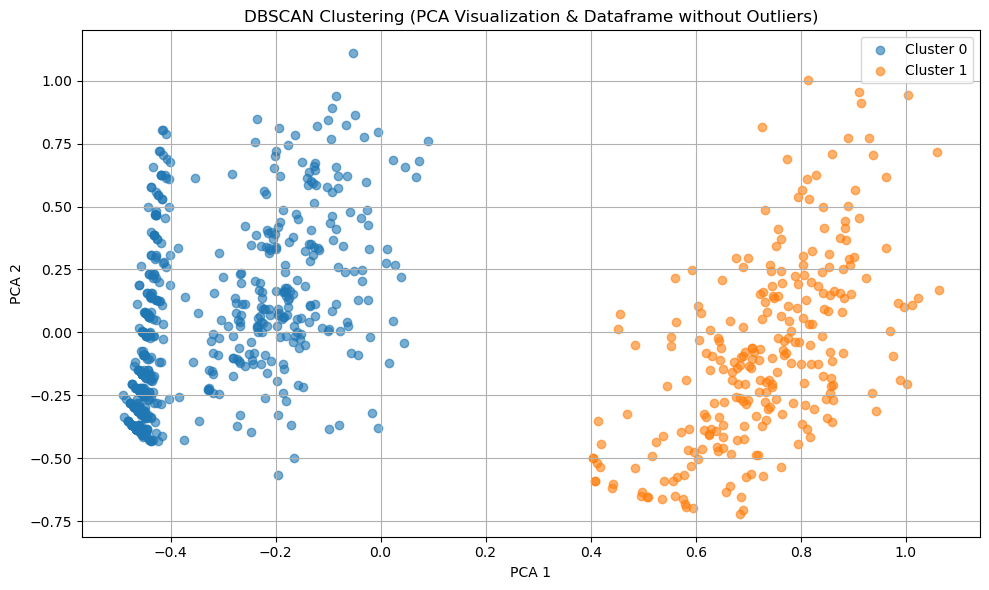

In [95]:
# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_num in set(df_no_outliers['DBSCAN_Cluster']):
    if cluster_num == -1:
        subset = data_pca[df_no_outliers['DBSCAN_Cluster'] == cluster_num]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Outliers", alpha=0.6, color='black')
    else:
        subset = data_pca[df_no_outliers['DBSCAN_Cluster'] == cluster_num]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_num}", alpha=0.6)

plt.title('DBSCAN Clustering (PCA Visualization & Dataframe without Outliers)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

## SOM

In [ ]:
#!pip install minisom

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom

In [ ]:
#.... Importing the dataset
df_som = pd.read_csv("earthquake_1995-2023.csv")

<br>

## K-Medoids

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

kmdf = df.copy()

### Elbow Method for finding the optimal number of clusters for K-medoids

#### Elbow Method for MinMaxScaler

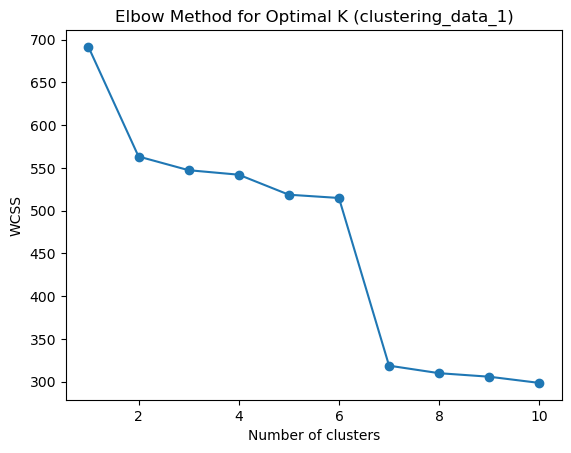

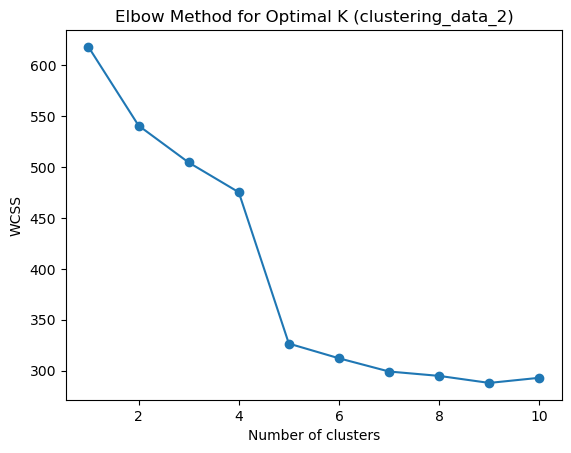

In [97]:
# Find optimal K for clustering_data_1
wcss_1 = []
for k in range(1, 11):
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(minmax_data_scaled_1)
    wcss_1.append(kmedoids.inertia_)

# Plot the Elbow Method for clustering_data_1
plt.plot(range(1, 11), wcss_1, marker='o')
plt.title('Elbow Method for Optimal K (clustering_data_1)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Find optimal K for clustering_data_2
wcss_2 = []
for k in range(1, 11):
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(minmax_data_scaled_2)
    wcss_2.append(kmedoids.inertia_)

# Plot the Elbow Method for clustering_data_2
plt.plot(range(1, 11), wcss_2, marker='o')
plt.title('Elbow Method for Optimal K (clustering_data_2)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


*   From the graph, we can see that the elbow for cluster_data_1 is **2**
*   Elbow for cluster_data_2 is **5**

#### Elbow for StandardScaler

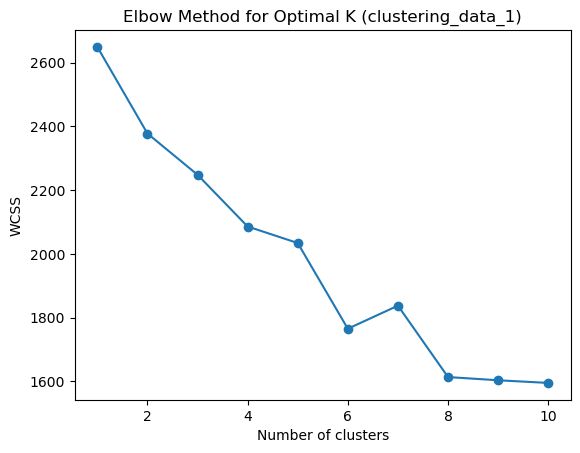

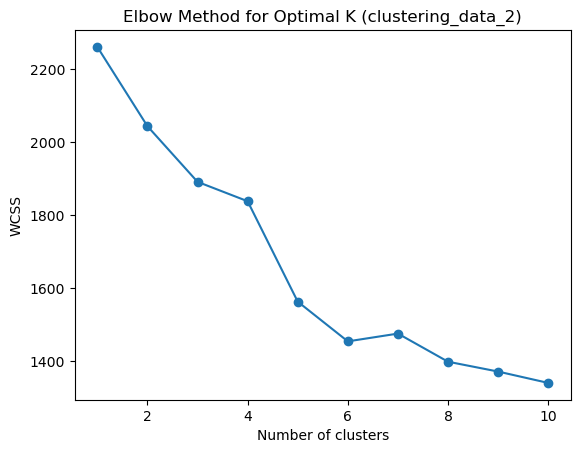

In [98]:
# Standardize the data
scaler = StandardScaler()
scaled_data_1 = scaler.fit_transform(clustering_data_1)
scaled_data_2 = scaler.fit_transform(clustering_data_2)

# Find optimal K for clustering_data_1
wcss_1 = []
for k in range(1, 11):
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(scaled_data_1)
    wcss_1.append(kmedoids.inertia_)

# Plot the Elbow Method for clustering_data_1
plt.plot(range(1, 11), wcss_1, marker='o')
plt.title('Elbow Method for Optimal K (clustering_data_1)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Find optimal K for clustering_data_2
wcss_2 = []
for k in range(1, 11):
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(scaled_data_2)
    wcss_2.append(kmedoids.inertia_)

# Plot the Elbow Method for clustering_data_2
plt.plot(range(1, 11), wcss_2, marker='o')
plt.title('Elbow Method for Optimal K (clustering_data_2)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


*   From the graph, we can see that the elbow for cluster_data_1 is **4**
*   Elbow for cluster_data_2 is **6**

### Average Silhouette Method to determine the optimal number of clusters

#### Average Silhouette Method for MinMaxScaler

In [99]:
# Function to plot silhouette scores and calculate average silhouette scores
def plot_silhouette(X, range_n_clusters):
    avg_silhouette_scores = []
    high = 0
    for n_clusters in range_n_clusters:

        clusterer = KMedoids(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        avg_silhouette_scores.append(silhouette_avg)  # Store the average silhouette score


        if silhouette_avg > high:
            high = silhouette_avg


        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)
    print("The Highers silhouette_score is :", high)
    # Plot the average silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(range_n_clusters[0], range_n_clusters[-1]+1), avg_silhouette_scores, marker='o', linestyle='--')
    plt.title('Average Silhouette Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.grid(True)
    plt.savefig('average_silhouette_scores.png')  # Save the figure
    plt.show()

# Range of clusters to try
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

For n_clusters = 2 The average silhouette_score is : 0.2928683237890046
For n_clusters = 3 The average silhouette_score is : 0.14017414072039425
For n_clusters = 4 The average silhouette_score is : 0.1228421383286984
For n_clusters = 5 The average silhouette_score is : 0.08675183894245149
For n_clusters = 6 The average silhouette_score is : 0.026702638233882844
For n_clusters = 7 The average silhouette_score is : 0.2570481367896945
For n_clusters = 8 The average silhouette_score is : 0.25586649759254587
The Highers silhouette_score is : 0.2928683237890046


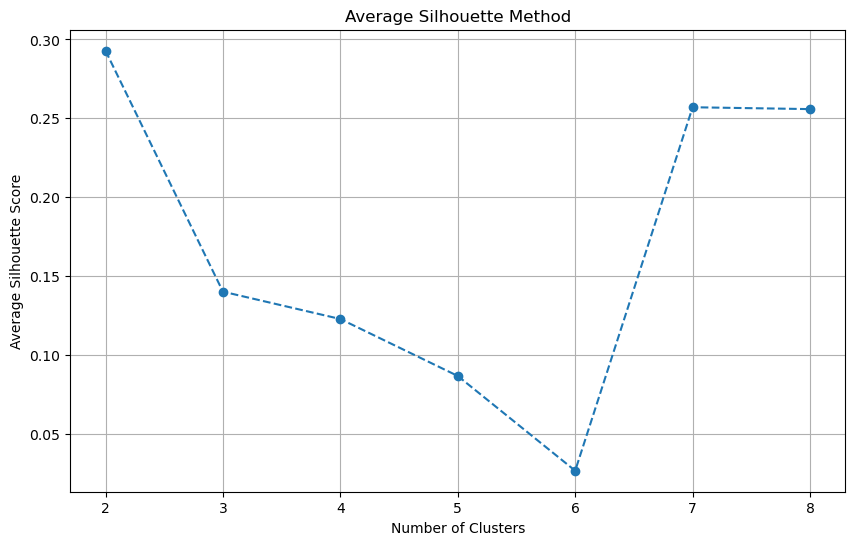

In [100]:
# Apply the function to minmax_data_scaled_1
plot_silhouette(minmax_data_scaled_1, range_n_clusters)

From the graph, the optimal cluster is **2** which has a score of approximately **0.2929**

For n_clusters = 2 The average silhouette_score is : 0.219156216537616
For n_clusters = 3 The average silhouette_score is : 0.2112149543229349
For n_clusters = 4 The average silhouette_score is : 0.18384686807263656
For n_clusters = 5 The average silhouette_score is : 0.3713143269740812
For n_clusters = 6 The average silhouette_score is : 0.32291882859698035
For n_clusters = 7 The average silhouette_score is : 0.3130055699334674
For n_clusters = 8 The average silhouette_score is : 0.2856924628802249
The Highers silhouette_score is : 0.3713143269740812


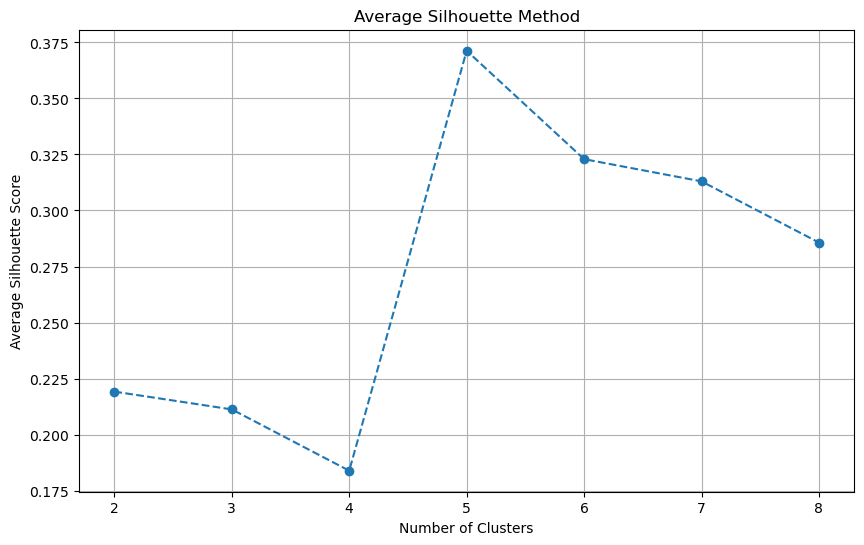

In [101]:
# Apply the function to minmax_data_scaled_2
plot_silhouette(minmax_data_scaled_2, range_n_clusters)

From the graph, the optimal cluster is **5** which has a score of approximately **0.3713**

#### Average Silhouette Method for StandardScaler

For n_clusters = 2 The average silhouette_score is : 0.16977381698278188
For n_clusters = 3 The average silhouette_score is : 0.15004881424544295
For n_clusters = 4 The average silhouette_score is : 0.19399012652276626
For n_clusters = 5 The average silhouette_score is : 0.1501964821447222
For n_clusters = 6 The average silhouette_score is : 0.18823025043797048
For n_clusters = 7 The average silhouette_score is : 0.09331321326707896
For n_clusters = 8 The average silhouette_score is : 0.1815021892444277
The Highers silhouette_score is : 0.19399012652276626


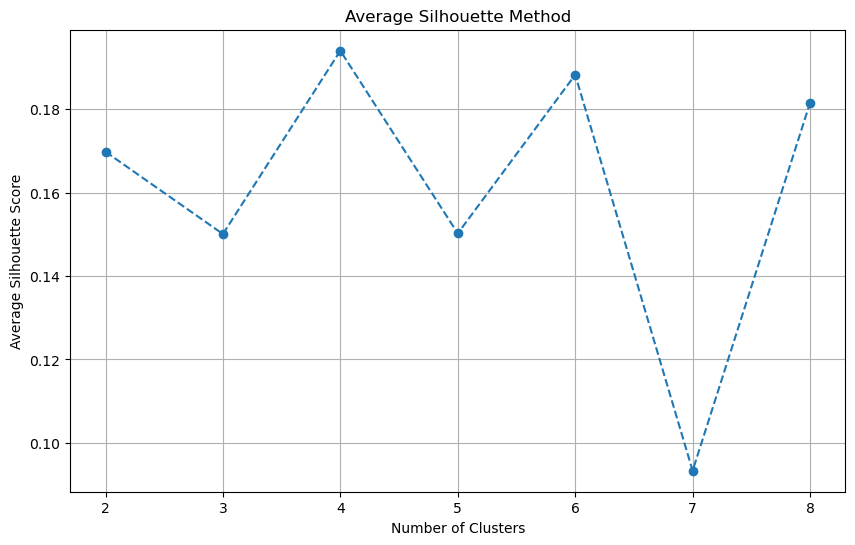

In [102]:
# Apply the function to scaled_data_1
plot_silhouette(scaled_data_1, range_n_clusters)

From the graph, the optimal cluster is **4** which has a score of approximately **0.1940**

For n_clusters = 2 The average silhouette_score is : 0.1762790320163241
For n_clusters = 3 The average silhouette_score is : 0.16802705105084595
For n_clusters = 4 The average silhouette_score is : 0.1347618796239657
For n_clusters = 5 The average silhouette_score is : 0.16192098598612847
For n_clusters = 6 The average silhouette_score is : 0.21337009635939516
For n_clusters = 7 The average silhouette_score is : 0.18383367320651092
For n_clusters = 8 The average silhouette_score is : 0.1886886575190055
The Highers silhouette_score is : 0.21337009635939516


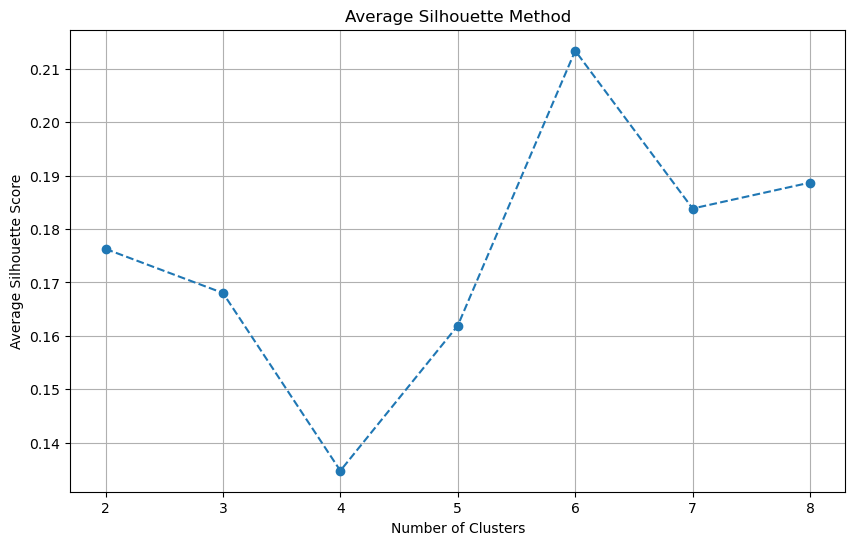

In [103]:
# Apply the function to clustering_data_2
plot_silhouette(scaled_data_2, range_n_clusters)

From the graph, the optimal cluster is **6** which has a score of approximately **0.2134**

### K-Medoids Using MinMaxScaler

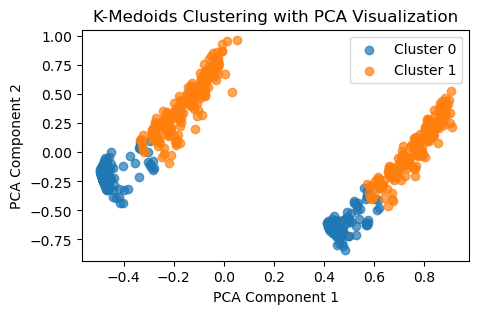

In [104]:
# Perform K-Medoids clustering
kmedoidsmin1 = KMedoids(n_clusters=2).fit(minmax_data_scaled_1)
labels = kmedoidsmin1.labels_

# Assign clusters to original data
df_cluster_with_kmedoids = pd.concat([kmdf, pd.DataFrame({'cluster': labels})], axis=1)

# Perform PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(minmax_data_scaled_1)

# Plot the clusters
plt.figure(figsize=(5, 3))
for cluster_label in set(labels):
    plt.scatter(pca_result[labels == cluster_label, 0],
                pca_result[labels == cluster_label, 1],
                label=f'Cluster {cluster_label}', alpha=0.7)
plt.title('K-Medoids Clustering with PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


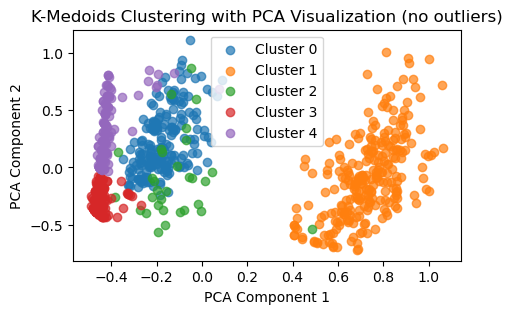

In [105]:
# Perform K-Medoids clustering for minmax_data_scaled_2
kmedoidsmin2 = KMedoids(n_clusters=5).fit(minmax_data_scaled_2)
labels = kmedoidsmin2.labels_

# Assign clusters to original data
df_cluster_with_kmedoids = pd.concat([kmdf, pd.DataFrame({'cluster': labels})], axis=1)

# Perform PCA for visualization
pca = PCA(n_components=5)
pca_result = pca.fit_transform(minmax_data_scaled_2)
# Plot the clusters
plt.figure(figsize=(5, 3))
for cluster_label in set(labels):
    plt.scatter(pca_result[labels == cluster_label, 0],
                pca_result[labels == cluster_label, 1],
                label=f'Cluster {cluster_label}', alpha=0.7)
plt.title('K-Medoids Clustering with PCA Visualization (no outliers)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


### K-Medoids Using StandardScaler

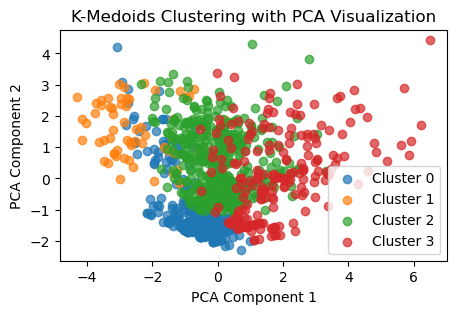

In [106]:
# Perform StandardScaler
scaler = StandardScaler()
st_data_scaled_1 = scaler.fit_transform(clustering_data_1)
kmedoidsst2 = KMedoids(n_clusters=4).fit(st_data_scaled_1)
labels = kmedoidsst2.labels_

# Assign clusters to original data
df_cluster_with_kmedoids = pd.concat([kmdf, pd.DataFrame({'cluster': labels})], axis=1)

# Perform PCA for visualization
pca = PCA(n_components=4)
pca_result = pca.fit_transform(st_data_scaled_1)

# Plot the clusters
plt.figure(figsize=(5, 3))
for cluster_label in set(labels):
    plt.scatter(pca_result[labels == cluster_label, 0],
                pca_result[labels == cluster_label, 1],
                label=f'Cluster {cluster_label}', alpha=0.7)
plt.title('K-Medoids Clustering with PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


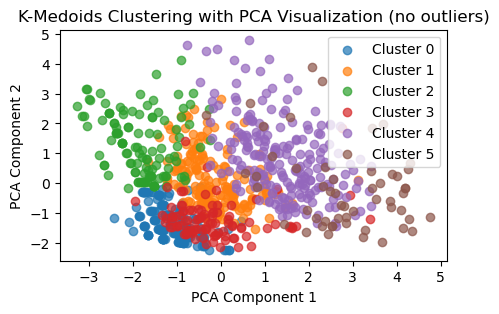

In [107]:
# Perform StandardScaler
st_data_scaled_2 = scaler.fit_transform(clustering_data_2)

# Perform K-Medoids clustering
kmedoidsst2 = KMedoids(n_clusters=6).fit(st_data_scaled_2)
labels = kmedoidsst2.labels_

# Assign clusters to original data
df_cluster_with_kmedoids = pd.concat([kmdf, pd.DataFrame({'cluster': labels})], axis=1)

# Perform PCA for visualization
pca = PCA(n_components=6)
pca_result = pca.fit_transform(st_data_scaled_2)

# Plot the clusters
plt.figure(figsize=(5, 3))
for cluster_label in set(labels):
    plt.scatter(pca_result[labels == cluster_label, 0],
                pca_result[labels == cluster_label, 1],
                label=f'Cluster {cluster_label}', alpha=0.7)
plt.title('K-Medoids Clustering with PCA Visualization (no outliers)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
